In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import pandas as pd
import tqdm

import torch
import torch_geometric.data

from utils import plot_gel_conds, compare_gel_conds

from sklearn.metrics.pairwise import cosine_similarity
from similarity import calculate_tanimoto_similarity, get_zeolite_similarity, maximum_mean_discrepancy, visualize_smiles

<frozen importlib._bootstrap>:241: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject
/home/synthesisproject/anaconda3/envs/zeo_diffusion/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
with open(f'ZeoSynGen_dataset.pkl', 'rb') as f: # load scaler
    dataset = pickle.load(f)

In [3]:
# Get all datapoints from dataset object
all_datapoints = dataset.get_datapoints_by_index([x for x in range(len(dataset))], scaled=False, return_dataframe=True)
# all_datapoints = dataset.get_datapoints_by_index([x for x in range(len(dataset))], scaled=True, return_dataframe=True)

# Create DataFrame with all datapoints
df = all_datapoints[1]
df['zeo'] = all_datapoints[3]
df['osda'] = all_datapoints[13]
df

Si/Al      Al/P  Si/Ge   Si/B  Na/T   K/T      OH/T  F/T      H2O/T  \
0      400.0  0.000000   99.0  250.0   0.0  0.05  0.250000  0.0  31.000006   
1      400.0  0.000000   99.0  250.0   0.0  0.00  0.000000  0.5   7.500000   
2      400.0  0.000000   99.0  250.0   0.0  0.12  0.270000  0.0  44.000000   
3      400.0  0.000000   99.0  250.0   0.0  0.00  0.000000  0.5  20.000000   
4        2.5  1.717997   99.0  250.0   0.0  0.00  2.285717  0.0  28.571430   
...      ...       ...    ...    ...   ...   ...       ...  ...        ...   
23956   30.0  1.717997   99.0  250.0   0.0  0.00  0.000000  0.0   0.000000   
23957   40.0  1.717997   99.0  250.0   0.0  0.00  0.000000  0.0   0.000000   
23958   70.0  1.717997   99.0  250.0   0.0  0.00  0.000000  0.0   0.000000   
23959  100.0  1.717997   99.0  250.0   0.0  0.00  0.000000  0.0   0.000000   
23960  300.0  1.717997   99.0  250.0   0.0  0.00  0.000000  0.0   0.000000   

         sda1/T  cryst_temp  cryst_time  zeo  \
0      0.200000  150.000000  504.000000  AFI   
1      0.500000  175.000000  168.000000  AFI   
2      0.150000  150.000000  144.000000  AFI   
3      0.000000  115.720856  660.165100  AFI   
4      1.142857  125.000000   72.000000  BPH   
...         ...         ...         ...  ...   
23956  0.000000  135.000000  558.916321  CHA   
23957  0.000000  160.000000  240.032150  CHA   
23958  0.000000  170.000000   53.891212  AFI   
23959  0.000000  170.000000  193.911392  AFI   
23960  0.000000  160.000000  342.733093  AFI   

                                                    osda  
0      C[N+]12CCCC[C@@H]1[C@H]1C[C@@H](C2)[C@@H]2CCCC...  
1      C[N+]12CCCC[C@@H]1[C@H]1C[C@@H](C2)[C@@H]2CCCC...  
2                        C[N+](C)(C)C12CC3CC(CC(C3)C1)C2  
3                        C[N+](C)(C)C12CC3CC(CC(C3)C1)C2  
4                                       CC[N+](CC)(CC)CC  
...                                                  ...  
23956                       CC[N+]1(CC)CC2CC3CC(C2)CC1C3  
23957                       CC[N+]1(CC)CC2CC3CC(C2)CC1C3  
23958                       CC[N+]1(CC)CC2CC3CC(C2)CC1C3  
23959                       CC[N+]1(CC)CC2CC3CC(C2)CC1C3  
23960                       CC[N+]1(CC)CC2CC3CC(C2)CC1C3  

[23961 rows x 14 columns]

In [4]:
# # Standard scaling (for MMD) - to be deleted
# from sklearn.preprocessing import StandardScaler
# scaler = StandardScaler()
# zeos = df['zeo']
# osdas = df['osda']
# df = pd.DataFrame(scaler.fit_transform(df.drop(columns=['zeo', 'osda'])), columns=dataset.ratio_names+dataset.cond_names)
# df['zeo'] = zeos
# df['osda'] = osdas
# df

# (Just) OSDA similarity

In [5]:
osda_sims, syn_sims = [], []
zeos, osda_refs, osda_srcs = [], [], []
for zeo, c in df['zeo'].value_counts().items():

    if zeo != 'Dense/Amorphous':
        print(zeo)
        df_zeo = df[df['zeo']==zeo]
        df_zeo = df_zeo.drop(columns=['zeo'])

        unique_osdas = list(df_zeo['osda'].value_counts().keys()) # unique OSDAs for this zeolite
        print('n_syn:', c)
        print('n_osda:', len(unique_osdas))
        
        # osda_sims, syn_sims = [], [] # if you one to plot for each zeolite, but need to uncomment the top 2 lines

        for ref_idx in range(len(unique_osdas)):
            osda_ref = unique_osdas[ref_idx] # Reference OSDA
            df_zeo_osda_ref = df_zeo[df_zeo['osda']==osda_ref].drop(columns=['osda']) 

            for src_idx in range(ref_idx): # Lower triangular matrix WITHOUT diagonal (diagonal is self-similarity, which is not useful)
                osda_src = unique_osdas[src_idx] # Source OSDA
                df_zeo_osda_src = df_zeo[df_zeo['osda']==osda_src].drop(columns=['osda'])

                # 1) OSDA SIMILARITY
                if (osda_ref == 'OSDA-free') or (osda_src == 'OSDA-free'):
                    osda_sim = 0.
                else:
                    osda_sim = calculate_tanimoto_similarity(osda_src, osda_ref, plot=False) # compare to refence OSDA

                # 2) SYNTHESIS SIMILARITY
                # 2A) Mean cosine similarity of all pairs of synthesis conditions
                syn_sim = cosine_similarity(df_zeo_osda_src.values, df_zeo_osda_ref.values) # n_samples_X, n_samples_Y
                syn_sim = syn_sim.mean() # scalar

                # 2B) Cosine similarity of mean synthesis conditions
                # syn_sim = cosine_similarity(df_zeo_osda_src.mean().values.reshape(1, -1), df_zeo_osda_ref.mean().values.reshape(1, -1))[0][0]

                # # 2C) Maximum Mean Discrepancy
                # syn_sim = maximum_mean_discrepancy(df_zeo_osda_src.values, df_zeo_osda_ref.values)

                osda_sims.append(osda_sim), syn_sims.append(syn_sim)
                zeos.append(zeo), osda_refs.append(osda_ref), osda_srcs.append(osda_src)
                
                # plot_gel_conds(df_zeo_osda_src, label='Current')
                # plot_gel_conds(df_zeo_osda_ref, label='Most \n freq. OSDA')
                # print()

        # # Plot OSDA vs synthesis similarity for specific zeolite
        # plt.figure(figsize=(5,5),dpi=100)
        # plt.scatter(osda_sims, syn_sims, alpha=0.1)
        # plt.xlabel('OSDA similarity')
        # plt.ylabel('Synthesis similarity')
        # plt.show()

MFI
n_syn: 2247
n_osda: 168
CHA
n_syn: 1419
n_osda: 92
BEA
n_syn: 1178
n_osda: 128
AFI
n_syn: 918
n_osda: 73
MTW
n_syn: 601
n_osda: 139
LTA
n_syn: 556
n_osda: 33
FAU
n_syn: 546
n_osda: 37
MOR
n_syn: 489
n_osda: 86
MWW
n_syn: 464
n_osda: 24
TON
n_syn: 377
n_osda: 35
AEL
n_syn: 347
n_osda: 15
FER
n_syn: 297
n_osda: 45
BEC
n_syn: 267
n_osda: 33
AEI
n_syn: 234
n_osda: 27
MTT
n_syn: 225
n_osda: 35
LEV
n_syn: 225
n_osda: 25
ANA
n_syn: 220
n_osda: 48
UTL
n_syn: 219
n_osda: 20
SOD
n_syn: 210
n_osda: 26
AEN
n_syn: 207
n_osda: 27
GIS
n_syn: 200
n_osda: 22
ISV/BEC
n_syn: 197
n_osda: 7
MEL
n_syn: 187
n_osda: 32
NON
n_syn: 186
n_osda: 53
STF
n_syn: 182
n_osda: 46
MRE
n_syn: 181
n_osda: 30
AST
n_syn: 147
n_osda: 38
ITH
n_syn: 144
n_osda: 2
EMT
n_syn: 143
n_osda: 9
IWR
n_syn: 140
n_osda: 8
ATO
n_syn: 134
n_osda: 8
ITQ-21
n_syn: 131
n_osda: 7
ERI
n_syn: 127
n_osda: 27
DDR
n_syn: 121
n_osda: 15
EUO
n_syn: 116
n_osda: 12
STW
n_syn: 114
n_osda: 13
MAZ
n_syn: 113
n_osda: 8
STO
n_syn: 112
n_osda: 27
RTH
n_

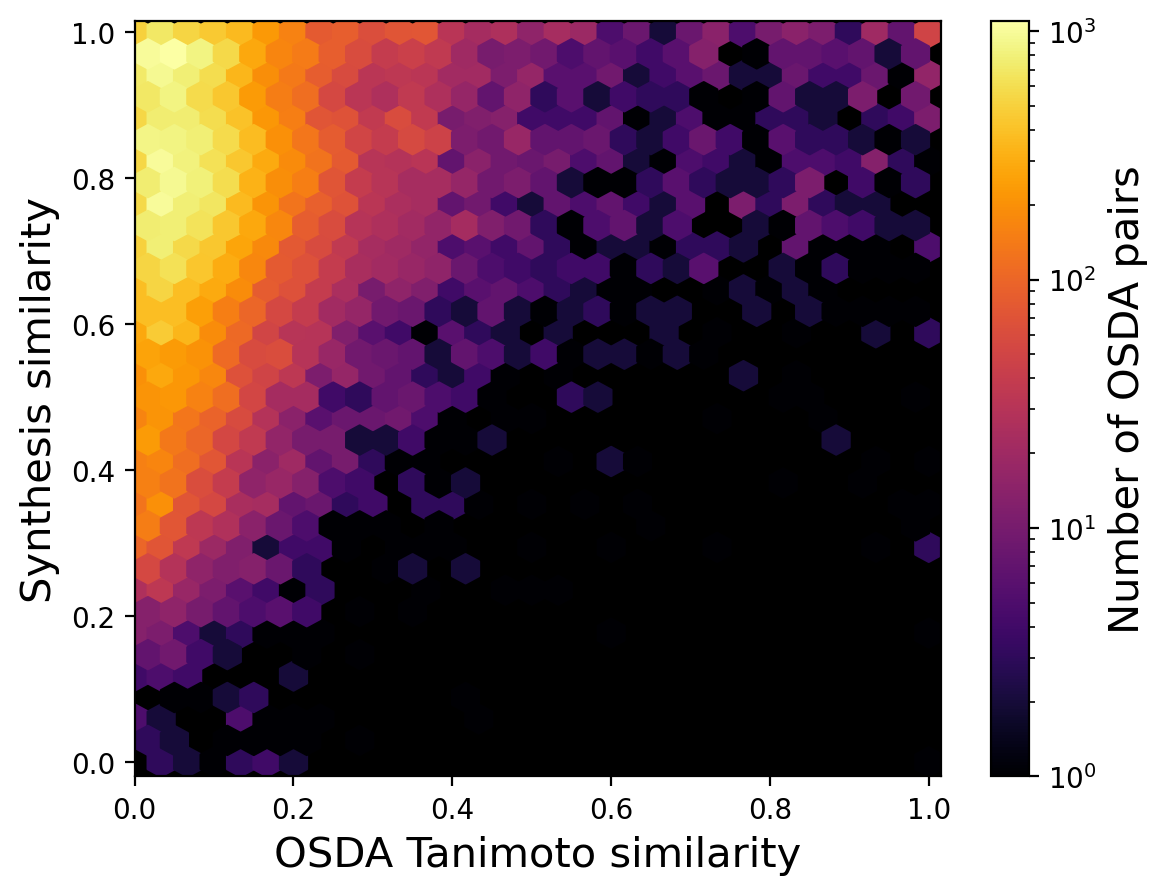

In [6]:
plt.figure(figsize=(6.5,5),dpi=200)
plt.hexbin(osda_sims, syn_sims, gridsize=30, mincnt=0, bins='log', cmap='inferno', facecolor='black')
ax = plt.gca()
ax.set_facecolor('black')
plt.xlabel('OSDA Tanimoto similarity', fontsize=15)
plt.ylabel('Synthesis similarity', fontsize=15)
cb = plt.colorbar()
cb.set_label('Number of OSDA pairs', fontsize=15)
plt.xlim(-0.00,1.015)
plt.ylim(-0.02,1.015)
# plt.xlim(-0.00,1.02)
# plt.ylim(-0.01,2)
plt.show()

In [8]:
df_osda_sim = pd.DataFrame({'zeo': zeos, 'osda_ref': osda_refs, 'osda_src': osda_srcs, 'osda_sim': osda_sims, 'syn_sim': syn_sims})
df_osda_sim = df_osda_sim.sort_values('osda_sim', ascending=False) # sort by OSDA similarity
df_osda_sim

zeo                              osda_ref  \
56396  SFS            CC[N+]1(CC)C(C)CCC2CCCCC21   
56397  SFS       CC[N+]1(CC)C(C)CC[C@@H]2CCCCC21   
38911  LTA                     C1COCCOCCOCCOCCN1   
44195  TON                          NCCCCCCCCCCN   
44112  TON  C[n+]1ccn(CCCCCCCCCCn2cc[n+](C)c2)c1   
...    ...                                   ...   
17016  CHA                      C1CNCCNCCCNCCNC1   
17015  CHA                      C1CNCCNCCCNCCNC1   
17014  CHA                      C1CNCCNCCCNCCNC1   
17013  CHA                      C1CNCCNCCCNCCNC1   
16972  CHA                      C1CNCCNCCCNCCNC1   

                                 osda_src  osda_sim   syn_sim  
56396      CC[N+]1(CC)C(C)CC[C@H]2CCCCC21       1.0  0.715194  
56397      CC[N+]1(CC)C(C)CC[C@H]2CCCCC21       1.0  0.950129  
38911                C1COCCOCCOCCOCCOCCN1       1.0  1.000000  
44195                      NCCCCCCCCCCCCN       1.0  0.993638  
44112  C[n+]1ccn(CCCCCCCCn2cc[n+](C)c2)c1       1.0  0.981474  
...                                   ...       ...       ...  
17016                             CCC(C)N       0.0  0.435288  
17015              CCN1C=CN(C)C1C(=O)[O-]       0.0  0.693650  
17014                               NCCCN       0.0  0.743370  
17013                                  CN       0.0  0.367784  
16972                     CC[n+]1ccn(C)c1       0.0  0.694413  

[56500 rows x 5 columns]

<Figure size 432x288 with 0 Axes>

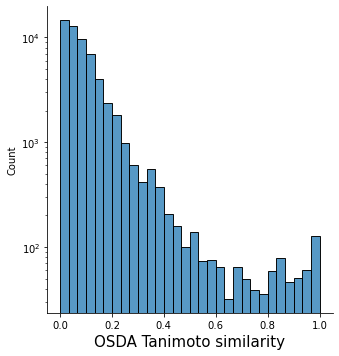

In [9]:
plt.figure()
sns.displot(df_osda_sim['osda_sim'], bins=30)
plt.xlabel('OSDA Tanimoto similarity', fontsize=15)
plt.yscale('log')

0
zeo: SFS
osda 1: CC[N+]1(CC)C(C)CC[C@H]2CCCCC21 7
osda 2: CC[N+]1(CC)C(C)CCC2CCCCC21 1
osda similarity: 1.0
synthesis similarity: 0.71519405


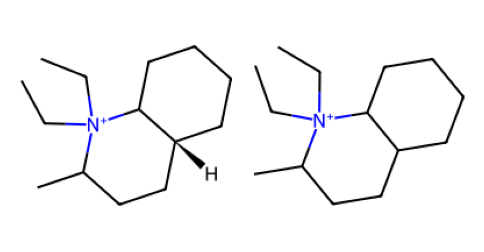

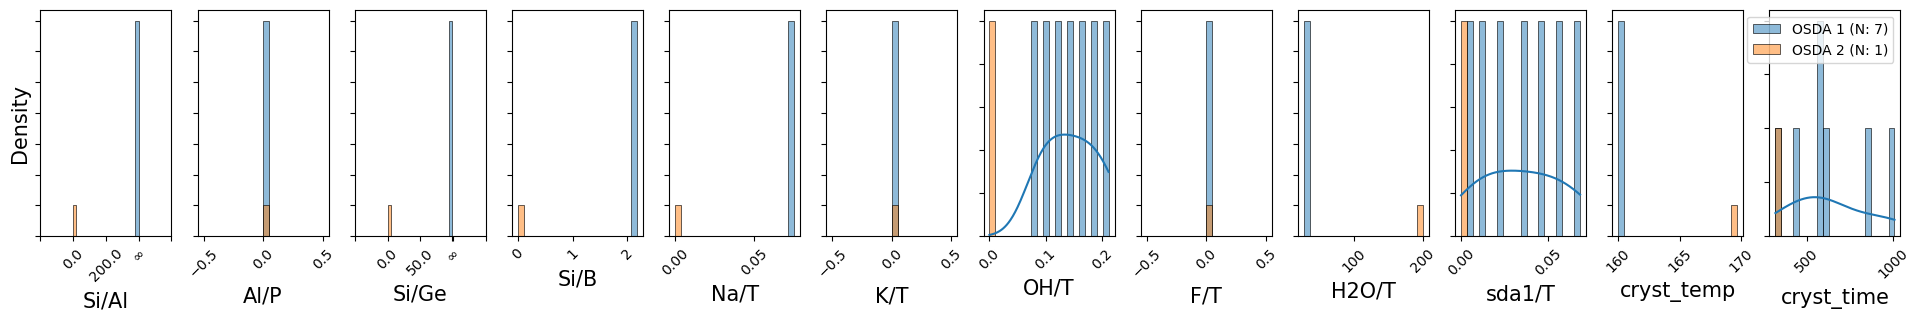

1
zeo: SFS
osda 1: CC[N+]1(CC)C(C)CC[C@H]2CCCCC21 7
osda 2: CC[N+]1(CC)C(C)CC[C@@H]2CCCCC21 1
osda similarity: 1.0
synthesis similarity: 0.9501292


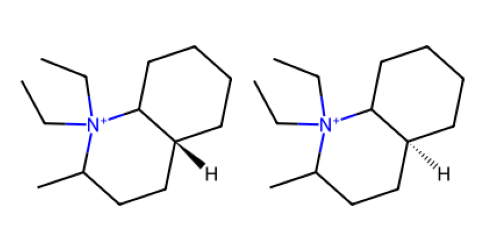

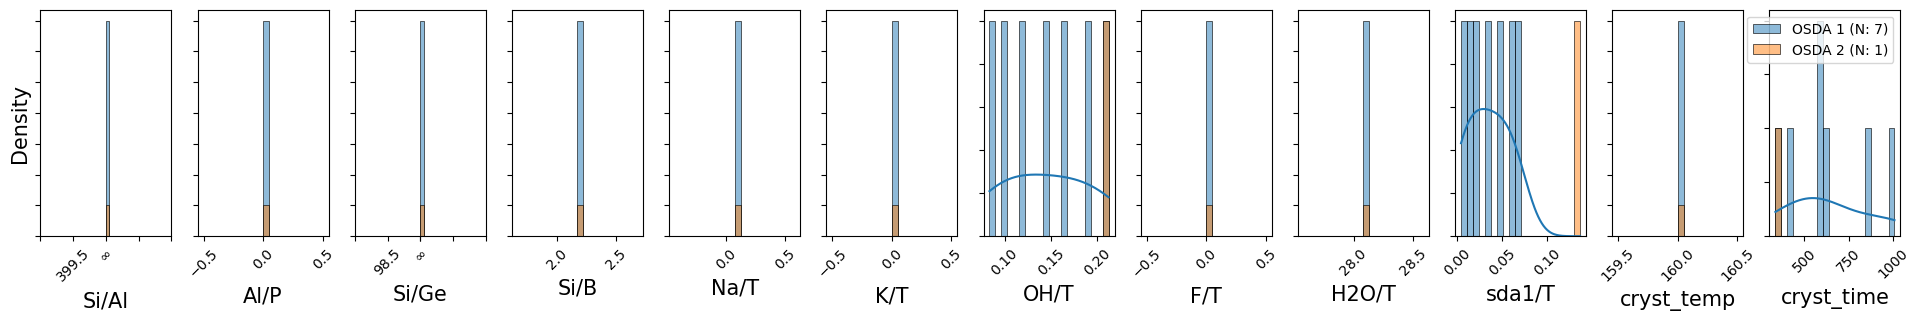

2
zeo: LTA
osda 1: C1COCCOCCOCCOCCOCCN1 1
osda 2: C1COCCOCCOCCOCCN1 1
osda similarity: 1.0
synthesis similarity: 1.0


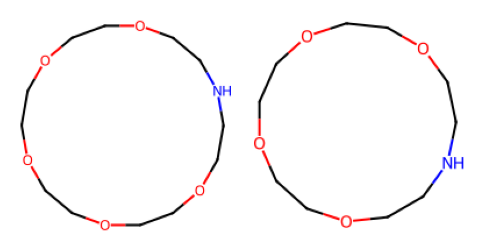

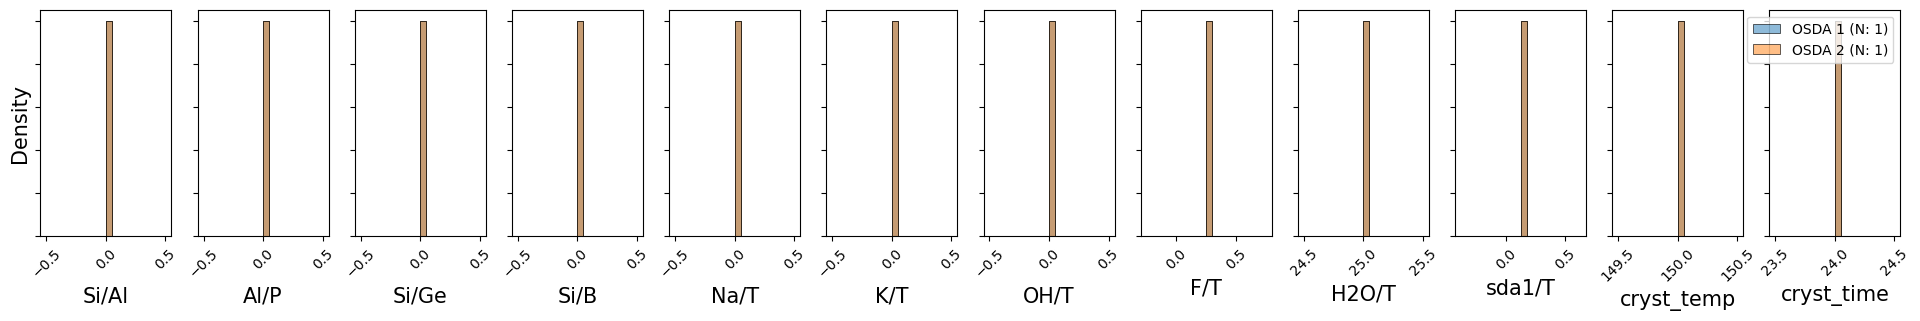

3
zeo: TON
osda 1: NCCCCCCCCCCCCN 7
osda 2: NCCCCCCCCCCN 1
osda similarity: 1.0
synthesis similarity: 0.9936379


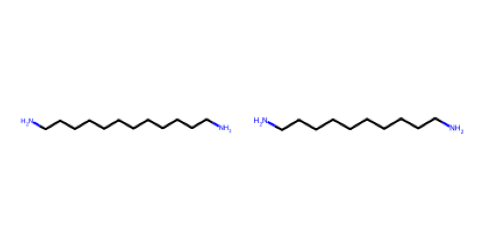

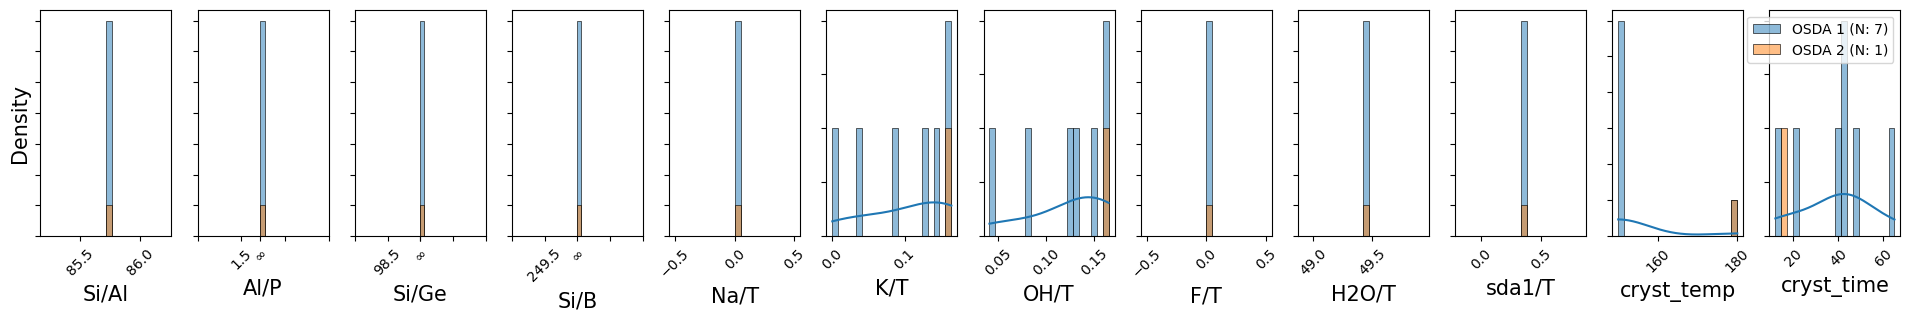

4
zeo: TON
osda 1: C[n+]1ccn(CCCCCCCCn2cc[n+](C)c2)c1 3
osda 2: C[n+]1ccn(CCCCCCCCCCn2cc[n+](C)c2)c1 1
osda similarity: 1.0
synthesis similarity: 0.9814744


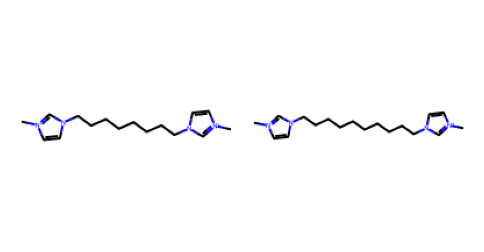

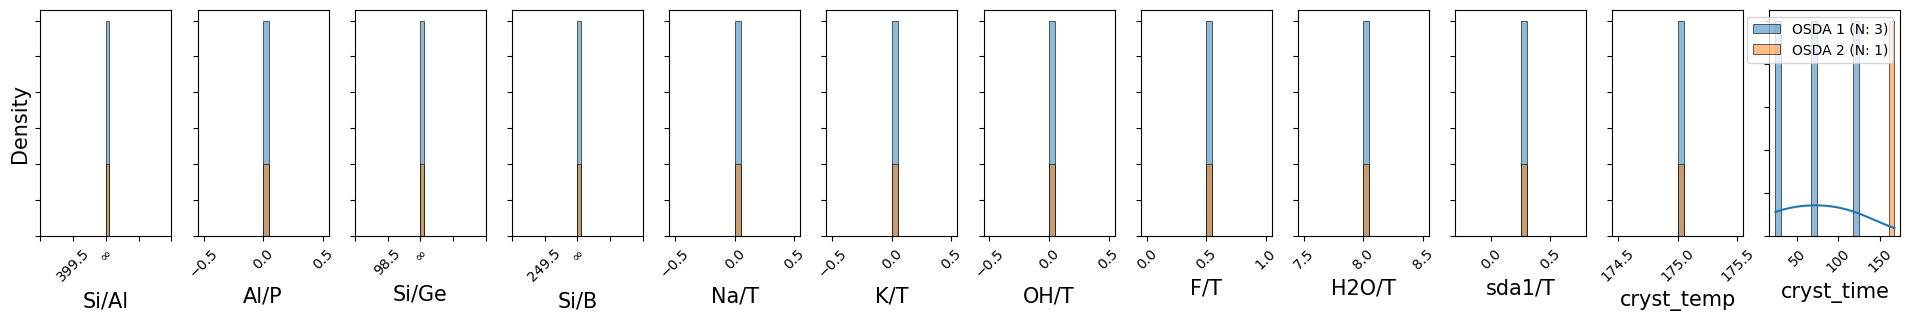

5
zeo: MRE
osda 1: C[N+](C)(C)CCCCCCCCCC[N+](C)(C)C 3
osda 2: C[N+](C)(C)CCCCCCCC[N+](C)(C)C 3
osda similarity: 1.0
synthesis similarity: 0.9225557


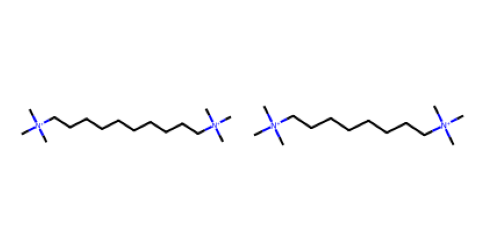

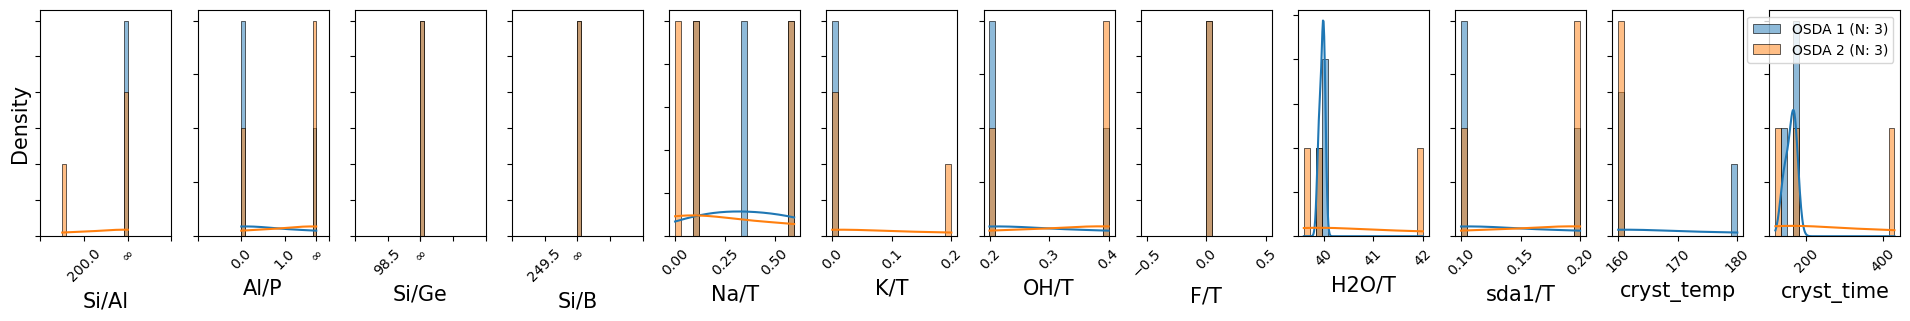

6
zeo: TON
osda 1: NCCCCCCCCN 14
osda 2: NCCCCCCCCCCN 1
osda similarity: 1.0
synthesis similarity: 0.86636555


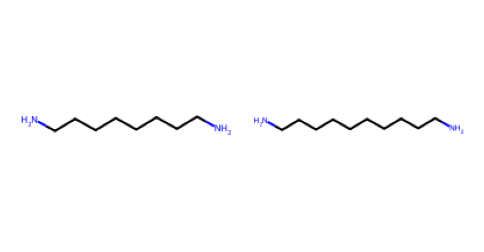

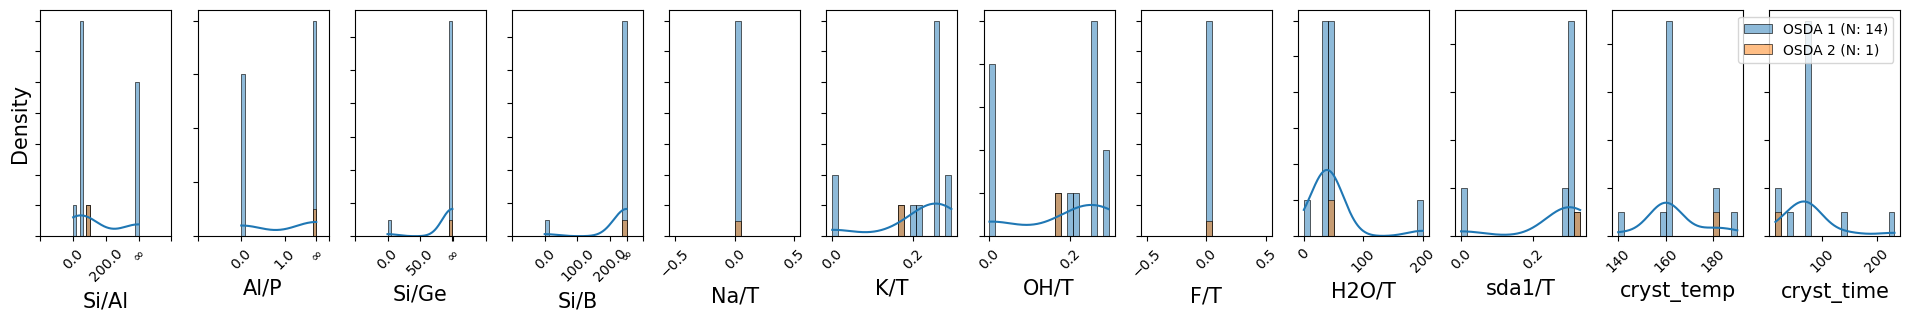

7
zeo: MTW
osda 1: C[N+](C)(C)CCCCCCCCC[N+](C)(C)C 1
osda 2: C[N+](C)(C)CCCCCCCCCC[N+](C)(C)C 1
osda similarity: 1.0
synthesis similarity: 0.9981285


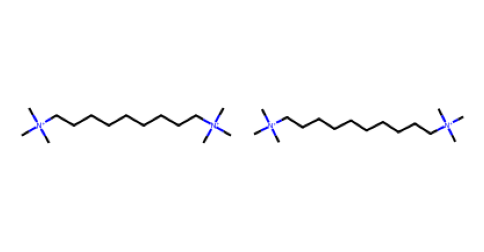

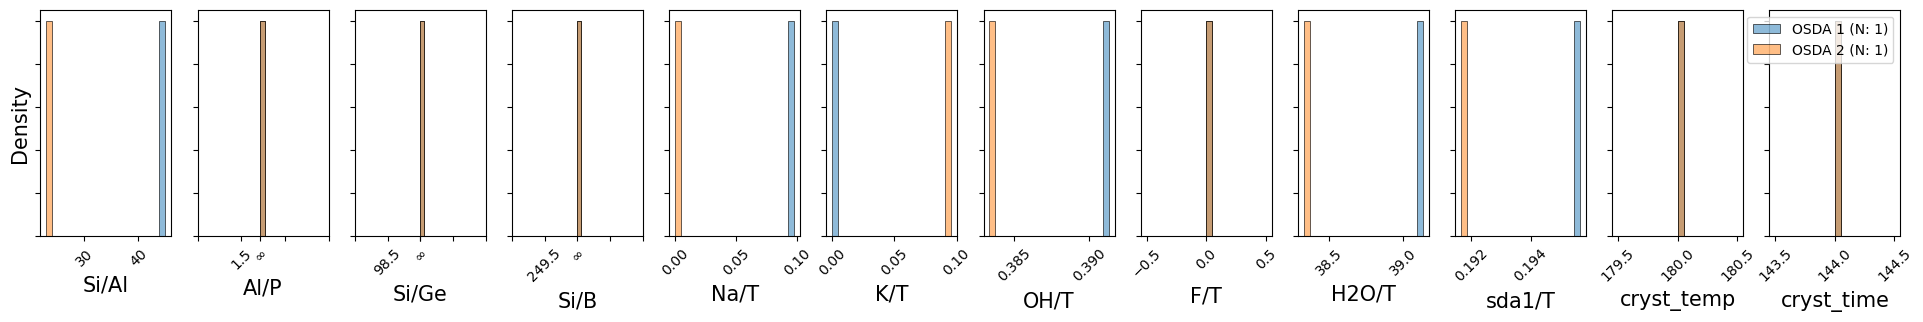

8
zeo: MTW
osda 1: C[N+](C)(C)CCCCCCCCCC[N+](C)(C)C 1
osda 2: C[N+](C)(C)CCCCCCCCCCCCCC[N+](C)(C)C 1
osda similarity: 1.0
synthesis similarity: 0.9526736


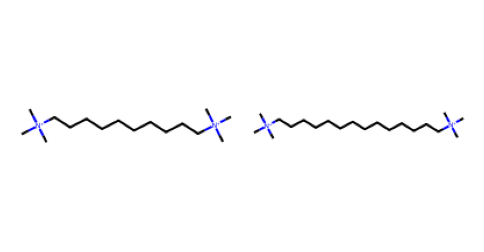

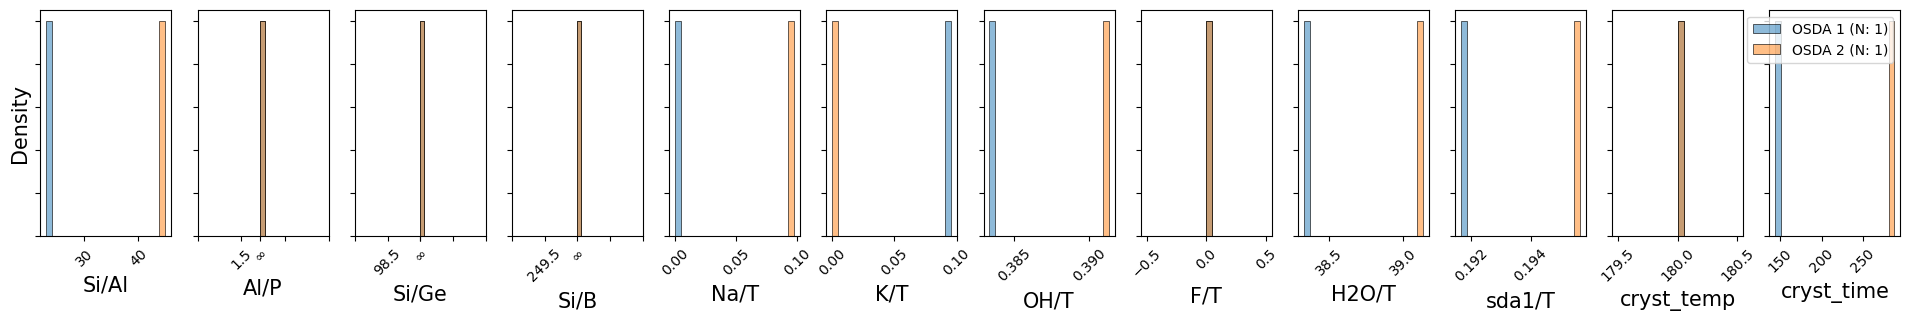

9
zeo: SFS
osda 1: CC[N+]1(CC)C(C)CCC2CCCCC21 1
osda 2: CC[N+]1(CC)C(C)CC[C@@H]2CCCCC21 1
osda similarity: 1.0
synthesis similarity: 0.60988677


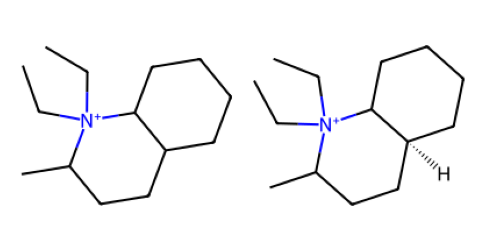

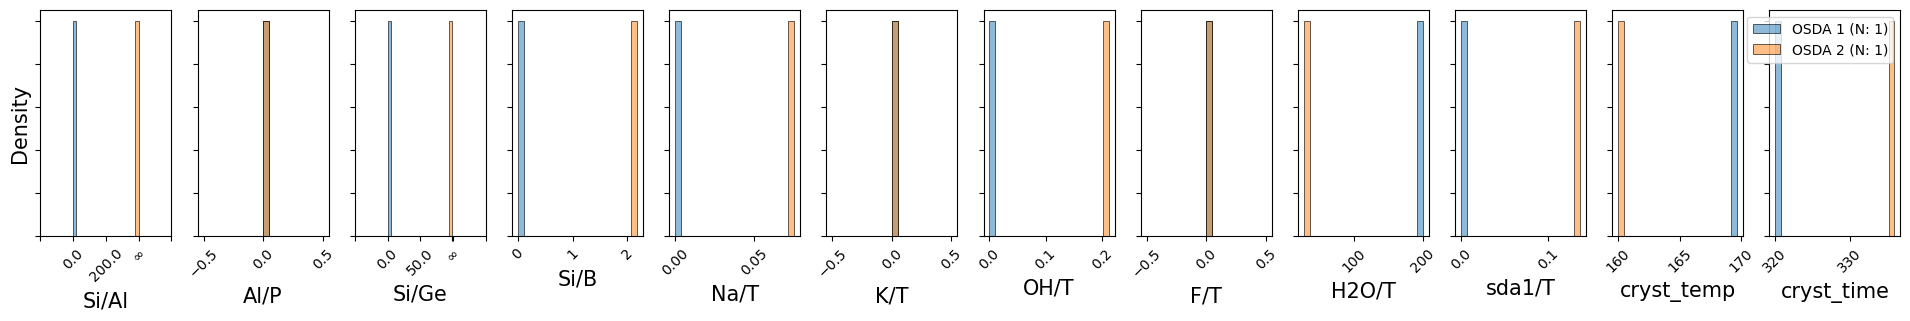

10
zeo: SSY
osda 1: CC[N+]1([C@H]2C[C@@H](C)CC(C)(C)C2)CCCC1 5
osda 2: CC[N+]1(C2CC(C)CC(C)(C)C2)CCCC1 1
osda similarity: 1.0
synthesis similarity: 0.95474684


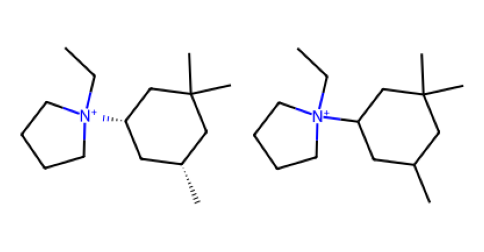

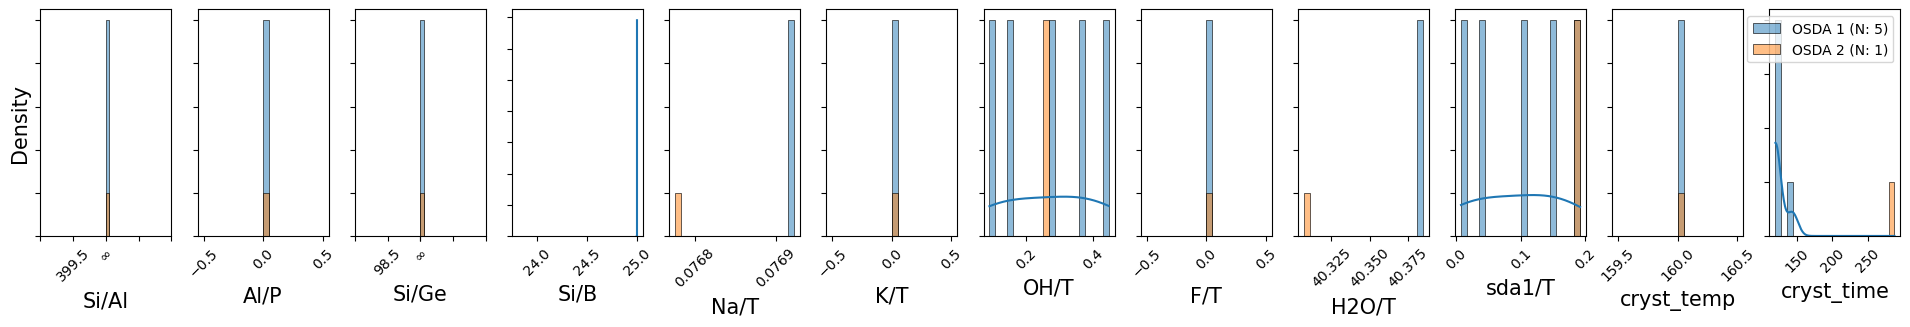

11
zeo: RTE
osda 1: N[C@@H]1C[C@H]2CC[C@@H]1C2 8
osda 2: NC1CC2CCC1C2 1
osda similarity: 1.0
synthesis similarity: 0.15990362


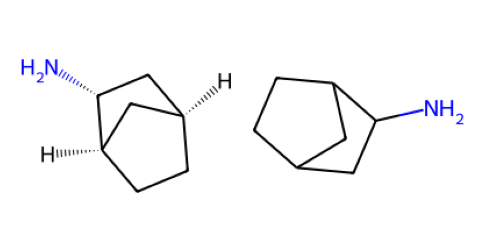

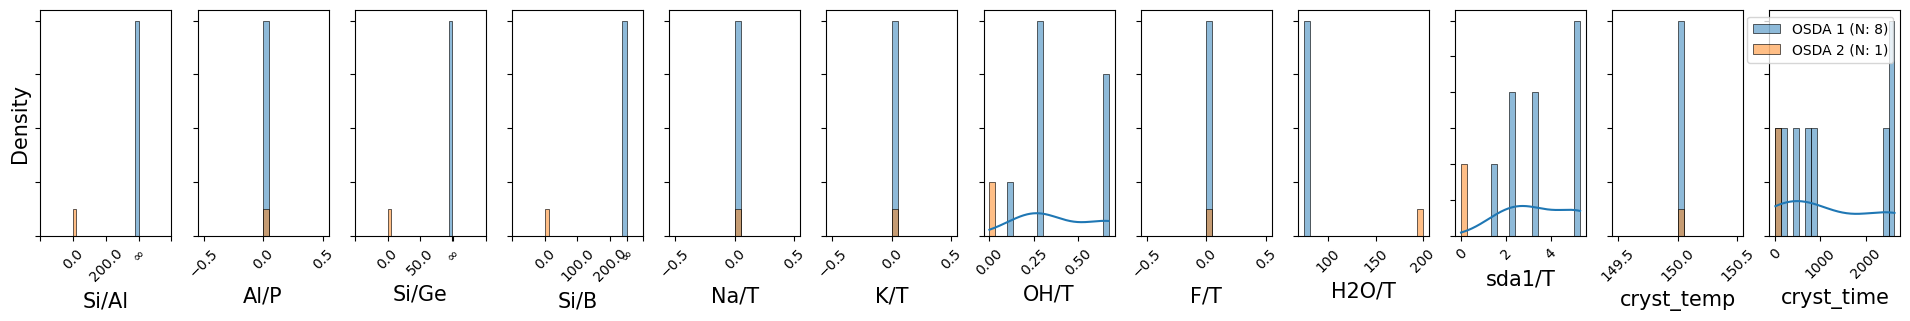

12
zeo: AFI
osda 1: C[C@@H]([C@H](O)c1ccccc1)N(C)Cc1ccccc1 4
osda 2: C[C@@H]([C@@H](O)c1ccccc1)N(C)Cc1ccccc1 4
osda similarity: 1.0
synthesis similarity: 0.99955434


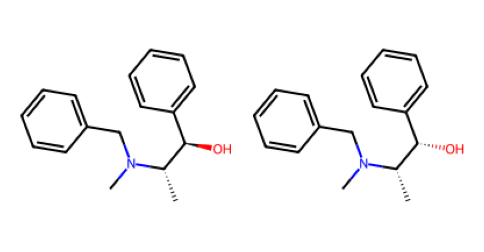

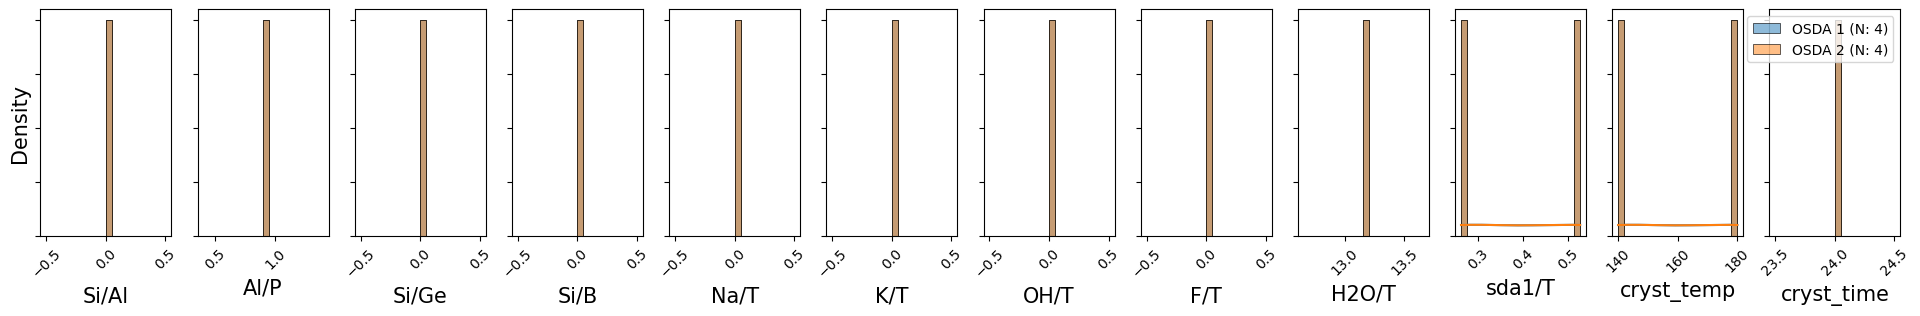

13
zeo: FAU
osda 1: C(CCN1CCOCCOCCOCCOCC1)CN1CCOCCOCCOCCOCC1 3
osda 2: C(CCN1CCOCCOCCOCCOCCOCC1)CN1CCOCCOCCOCCOCCOCC1 1
osda similarity: 1.0
synthesis similarity: 0.9999223


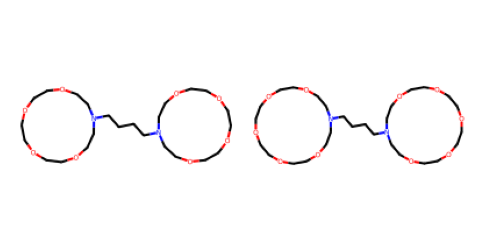

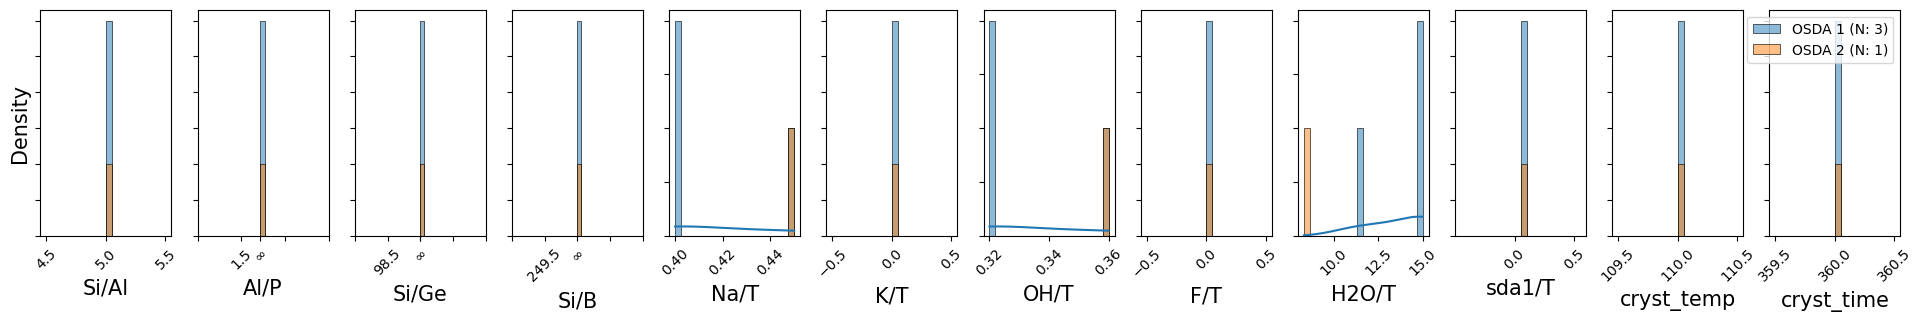

14
zeo: BEA
osda 1: Cc1c(C)[n+](CCCCCCCCCC[n+]2c(C)c(C)n(C)c2C)c(C)n1C 3
osda 2: Cc1c(C)[n+](CCCCCCCC[n+]2c(C)c(C)n(C)c2C)c(C)n1C 1
osda similarity: 1.0
synthesis similarity: 0.94074863


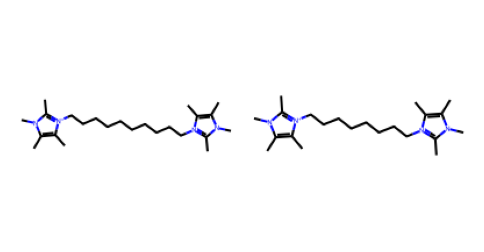

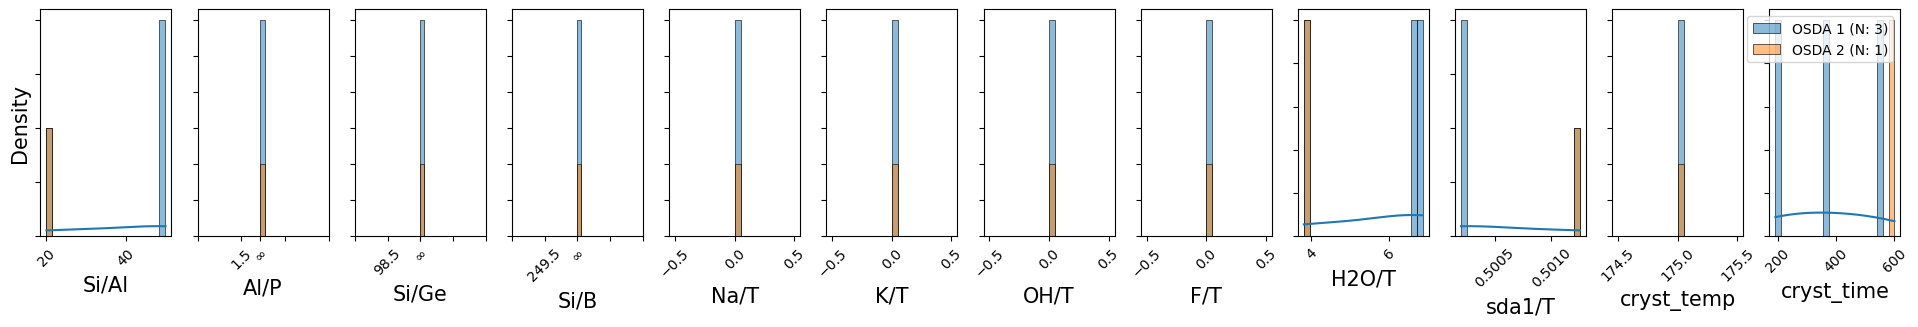

15
zeo: MFI
osda 1: CCCCCCCC[N+](C)(C)C 2
osda 2: CCCCCCCCCCCCCCCC[N+](C)(C)C 1
osda similarity: 1.0
synthesis similarity: 0.34171233


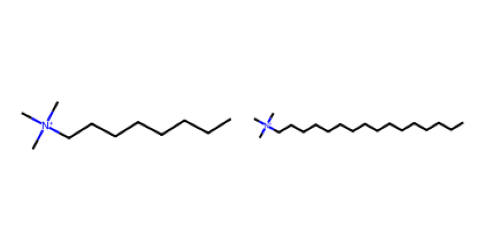

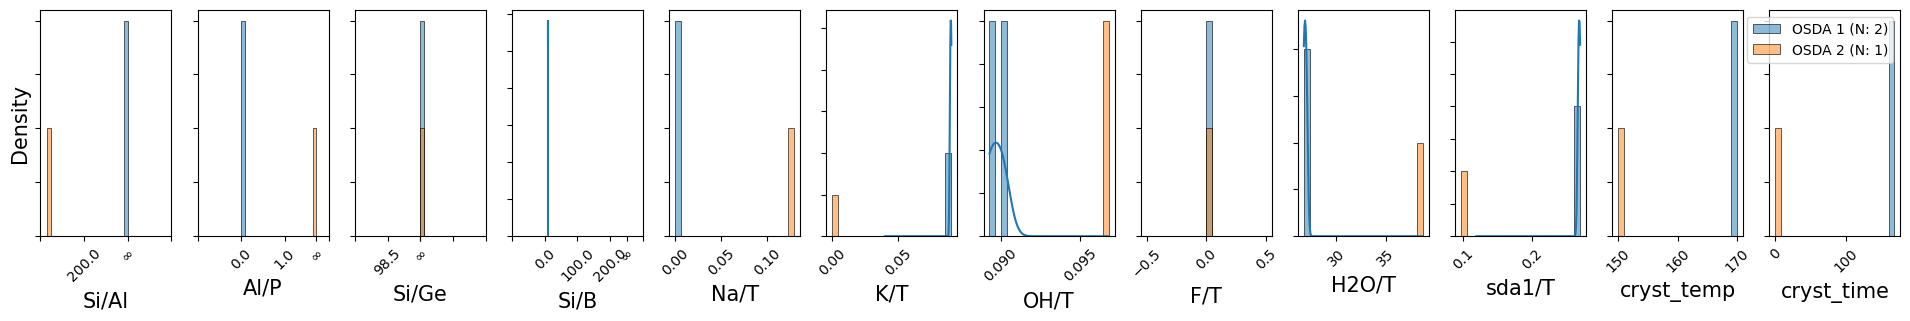

16
zeo: MEL
osda 1: NCCCCCCCCN 10
osda 2: NCCCCCCCCCCCCN 2
osda similarity: 1.0
synthesis similarity: 0.7198875


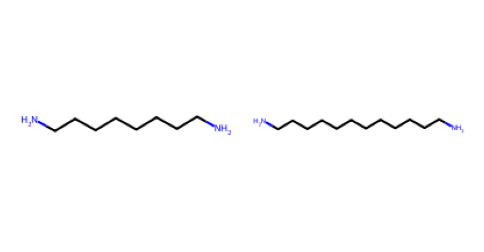

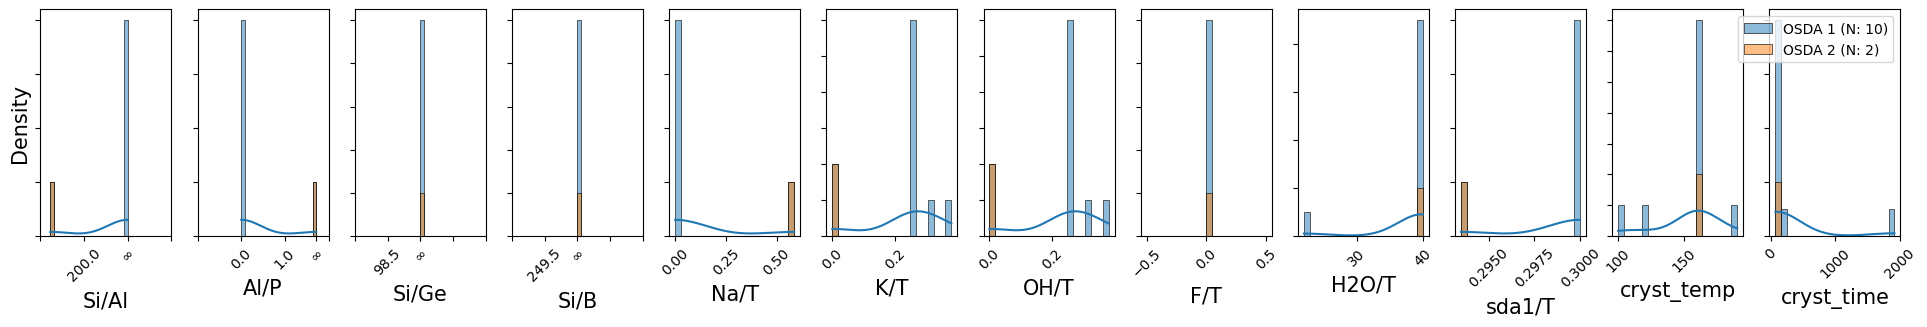

17
zeo: MTW
osda 1: C[N+](C)(C)CCCCCCCCC[N+](C)(C)C 1
osda 2: C[N+](C)(C)CCCCCCCCCCCCCC[N+](C)(C)C 1
osda similarity: 1.0
synthesis similarity: 0.95340633


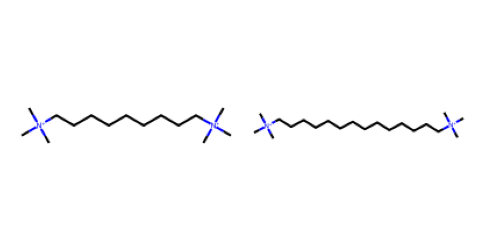

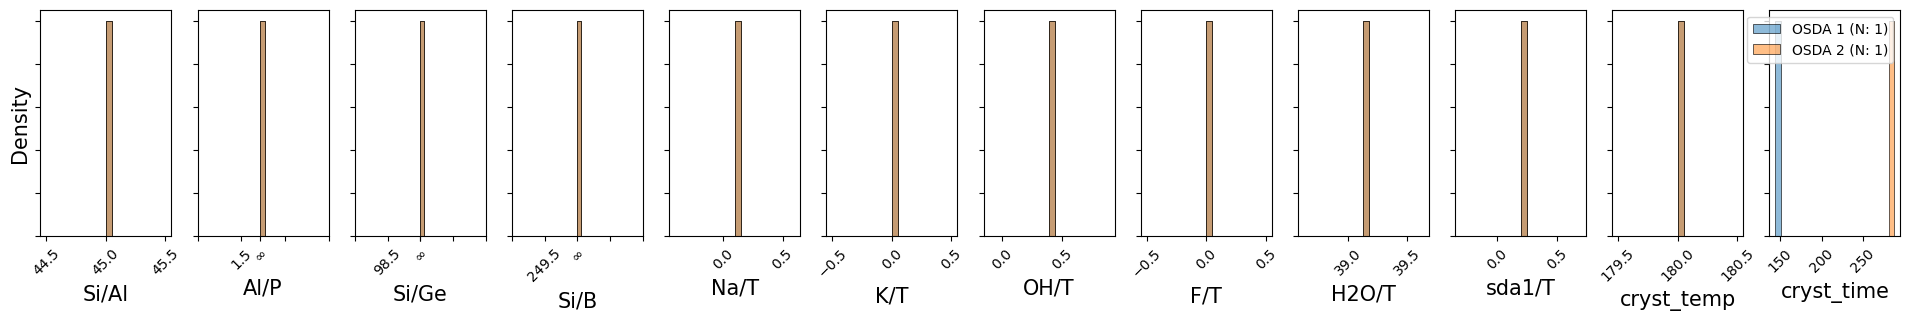

18
zeo: LTA
osda 1: C1COCCOCCOCCN1 1
osda 2: C1COCCOCCOCCOCCOCCN1 1
osda similarity: 1.0
synthesis similarity: 1.0


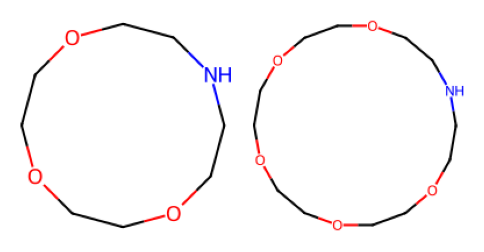

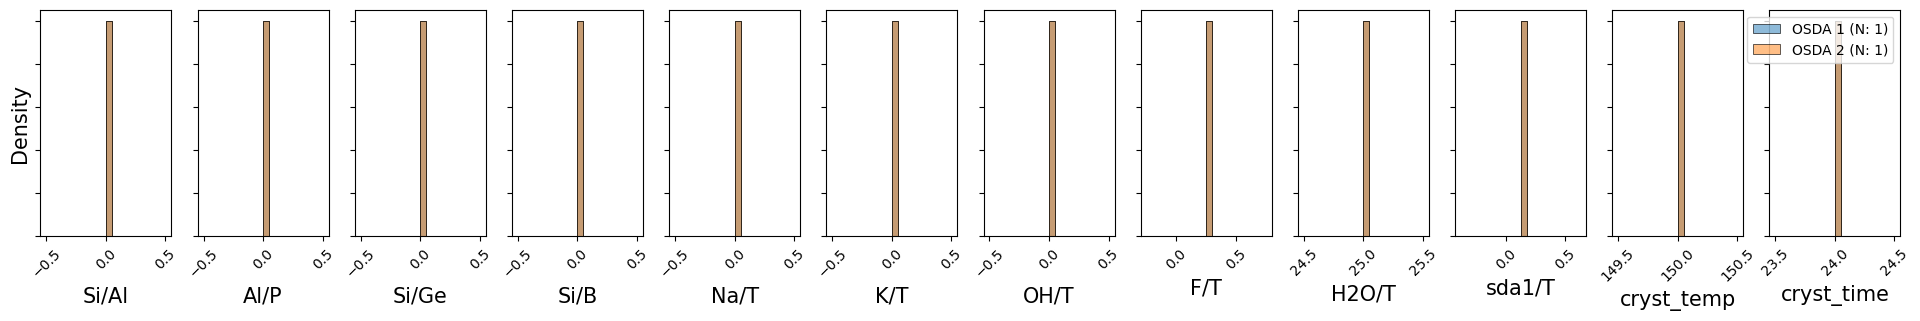

19
zeo: LTA
osda 1: C1COCCOCCOCCN1 1
osda 2: C1COCCOCCOCCOCCN1 1
osda similarity: 1.0
synthesis similarity: 1.0


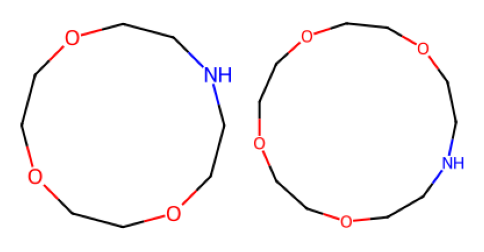

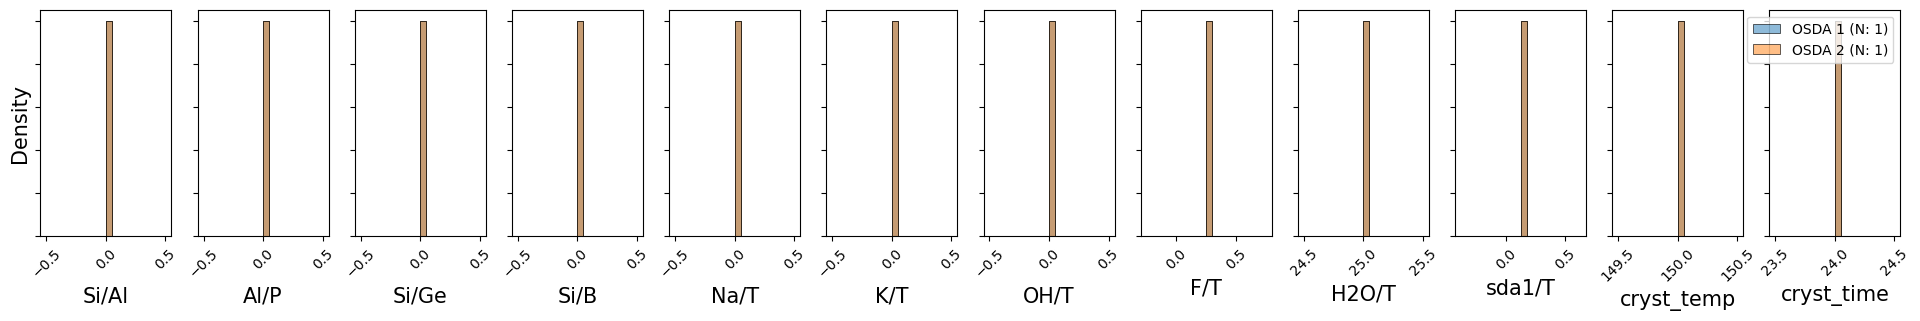

20
zeo: MFI
osda 1: C[n+]1ccn(CCCCCCCCCCn2cc[n+](C)c2)c1 9
osda 2: C[n+]1ccn(CCCCCCCCn2cc[n+](C)c2)c1 6
osda similarity: 1.0
synthesis similarity: 0.983047


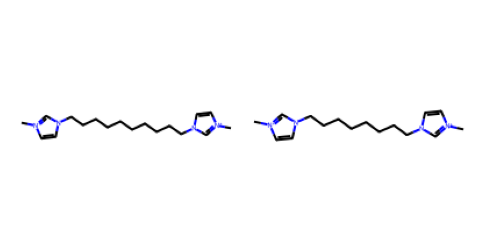

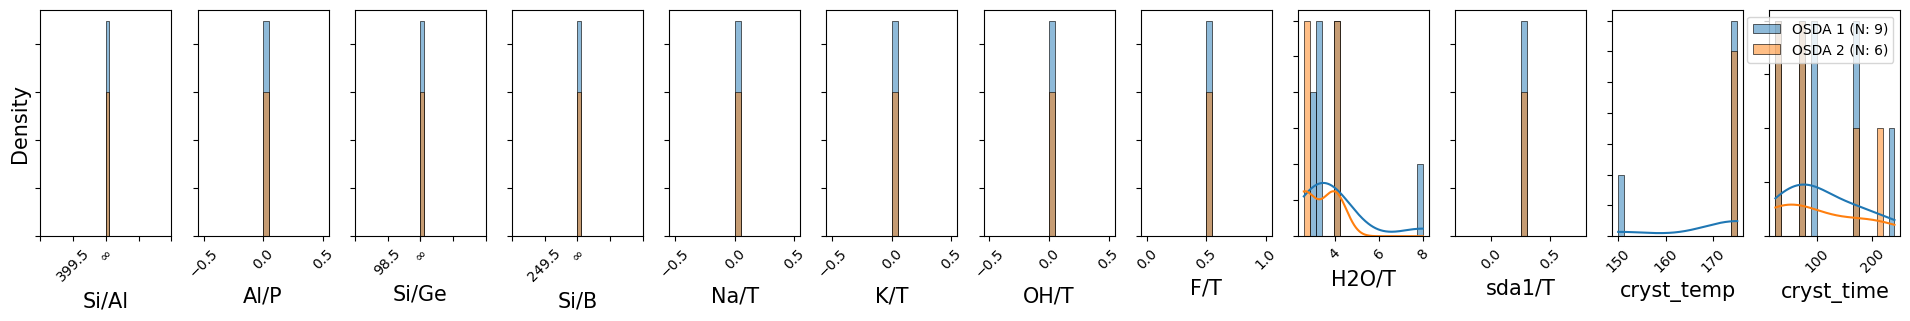

21
zeo: MFI
osda 1: CCCCCCCCCCCCCCCCCCCCCC[N+](C)(C)CCCCCC[N+](C)(C)CCCCCC[N+](C)(C)CCCCCC[N+](C)(C)CCCCCC 1
osda 2: CCCCCCCCCCCCCCCC[N+](C)(C)CCCCCC[N+](C)(C)CCCCCC 1
osda similarity: 1.0
synthesis similarity: 0.9984918


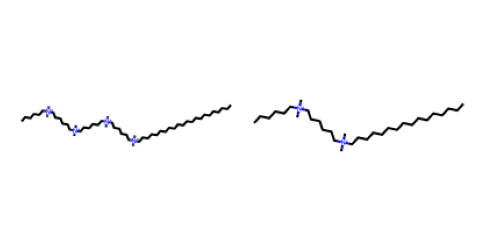

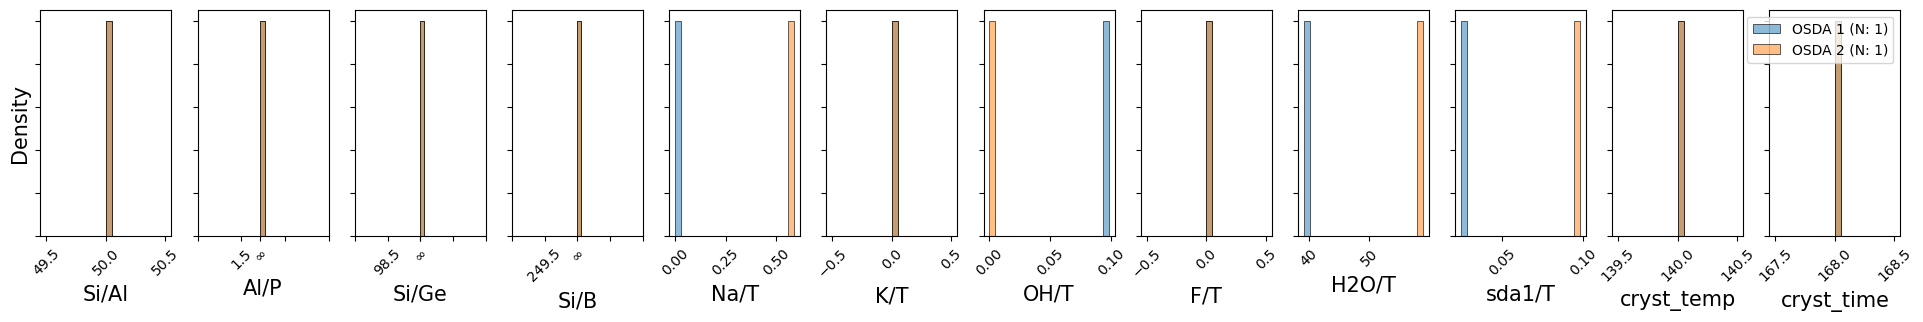

22
zeo: ANA
osda 1: CC[N+](CC)(CC)CCCCCCC[N+](CC)(CC)CC 1
osda 2: CC[N+](CC)(CC)CCCCCCCC[N+](CC)(CC)CC 1
osda similarity: 1.0
synthesis similarity: 1.0


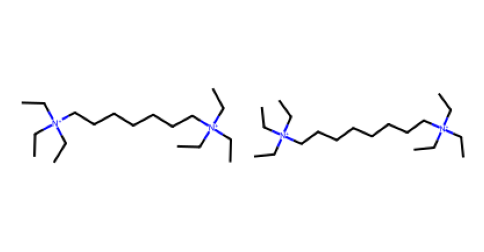

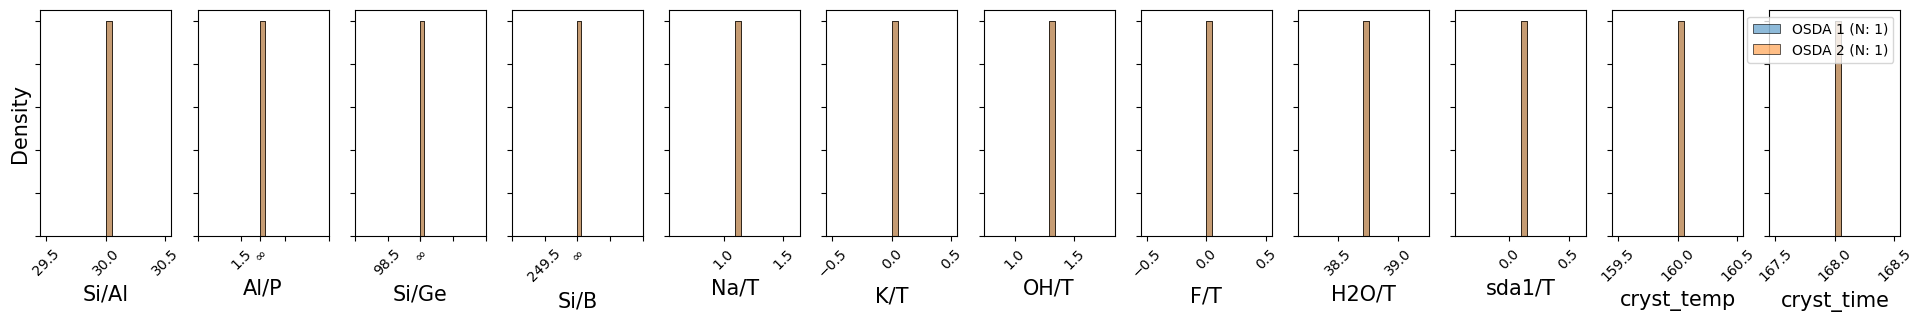

23
zeo: MSE
osda 1: CC[N+]1(CC)CC2C3C=CC(C2C1)C1C[N+](CC)(CC)CC31 18
osda 2: CC[N+]1(CC)C[C@H]2C3C=CC([C@@H]4C[N+](CC)(CC)C[C@H]34)[C@H]2C1 1
osda similarity: 1.0
synthesis similarity: 0.60409486


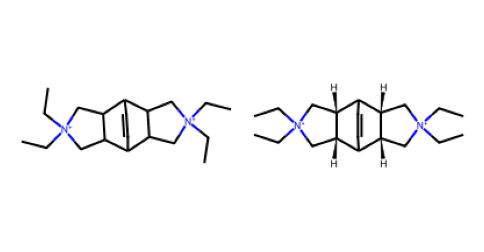

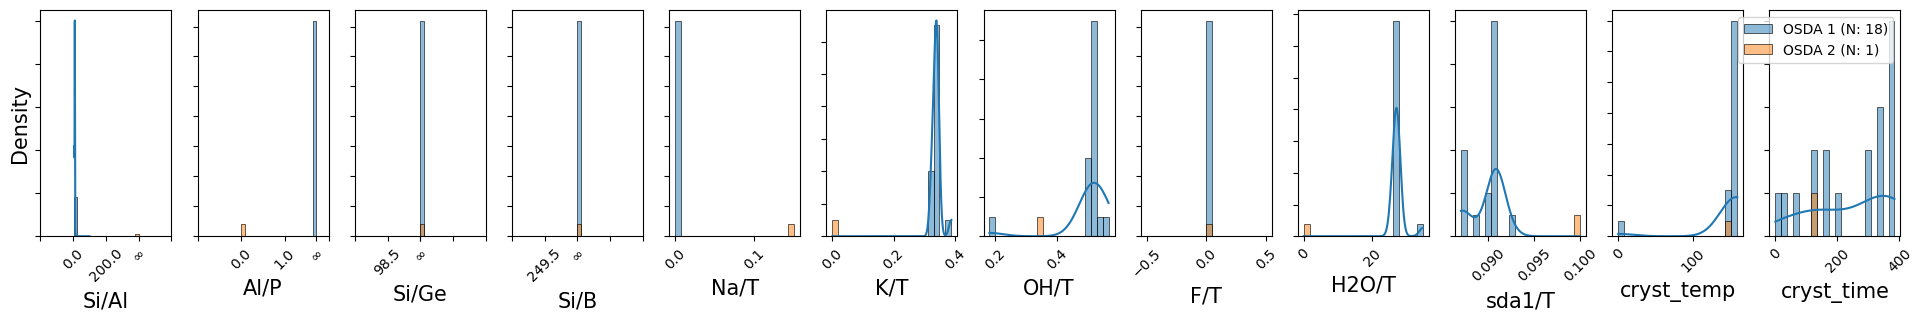

24
zeo: MFI
osda 1: CC[N+](CC)(CC)CCCCCCCC[N+](CC)(CC)CC 11
osda 2: CC[N+](CC)(CC)CCCCCCCCCC[N+](CC)(CC)CC 7
osda similarity: 1.0
synthesis similarity: 0.99929035


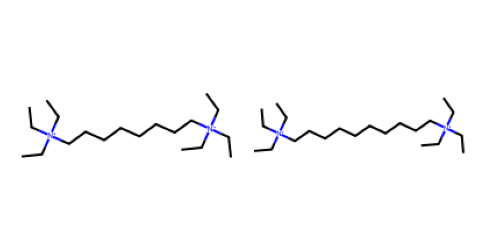

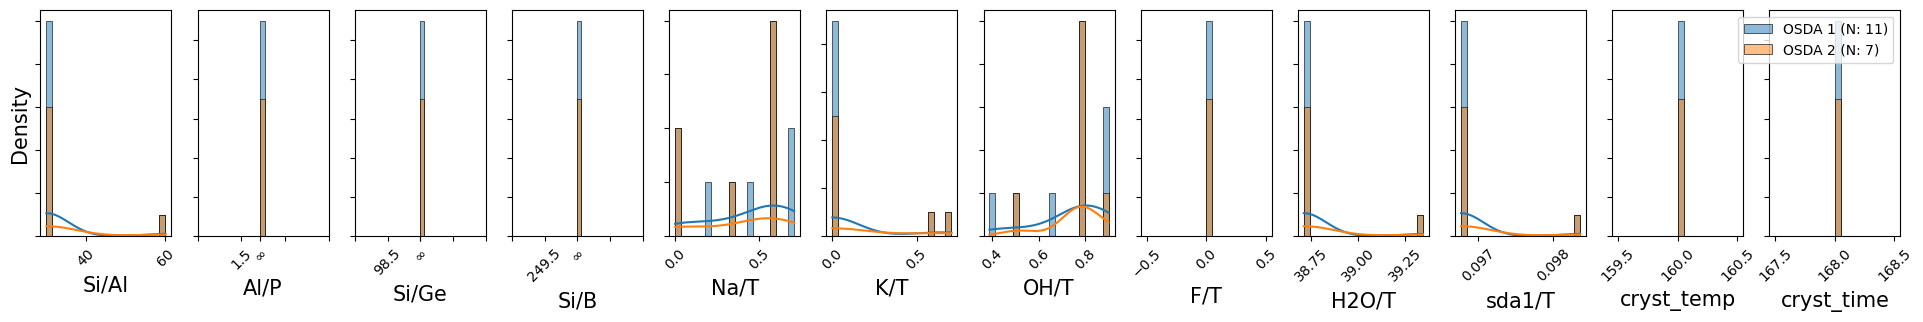

25
zeo: AEI
osda 1: C[C@H]1C[C@@H](C)C[N+](C)(C)C1 14
osda 2: C[C@H]1C[C@H](C)C[N+](C)(C)C1 1
osda similarity: 1.0
synthesis similarity: 0.9756538


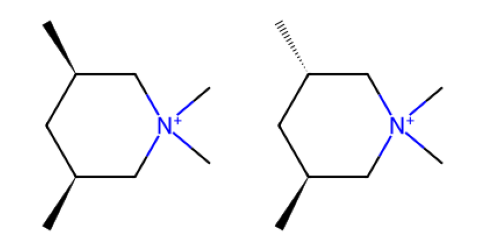

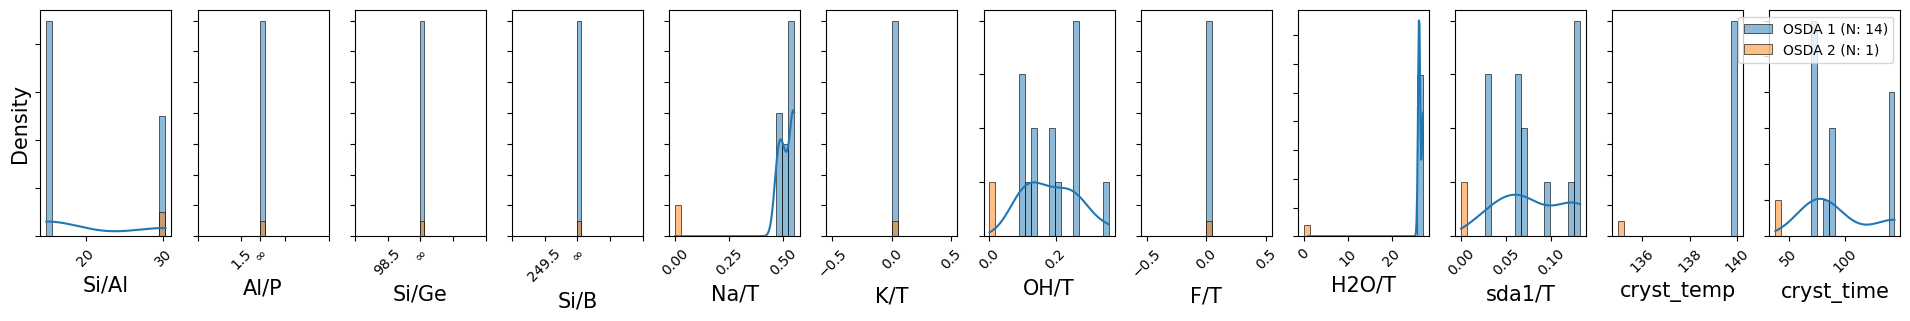

26
zeo: MFI
osda 1: C[N+](C)(C)CCCCCCCCCC[N+](C)(C)C 3
osda 2: C[N+](C)(C)CCCCCCCCC[N+](C)(C)C 2
osda similarity: 1.0
synthesis similarity: 0.8557172


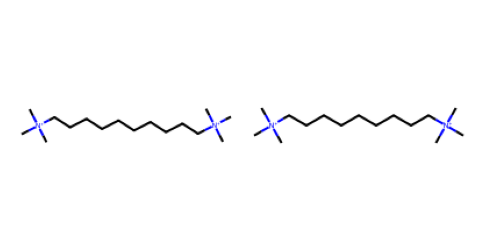

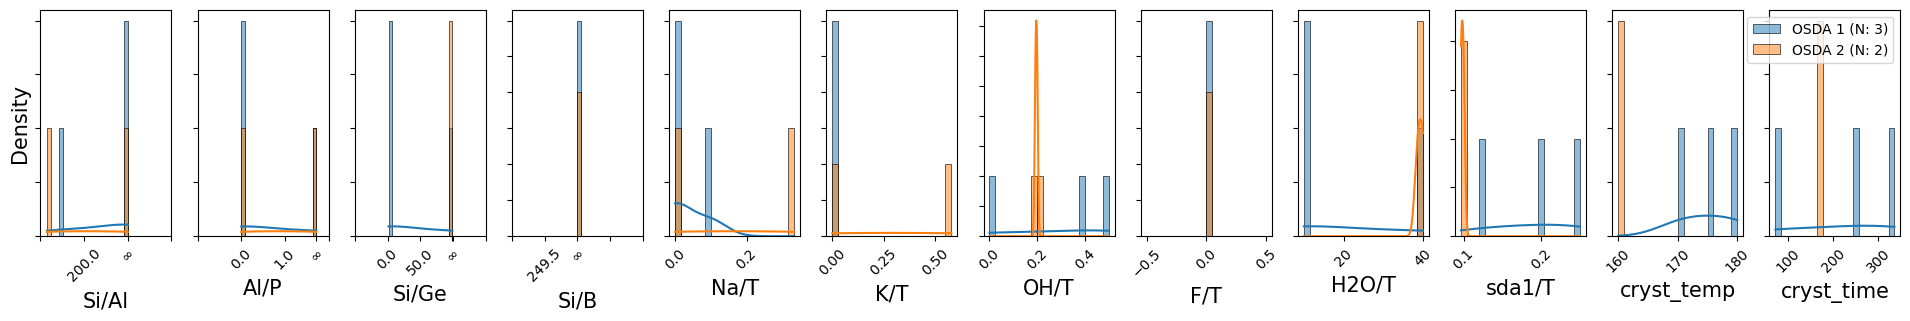

27
zeo: MRE
osda 1: CCCCCCCCC[N+](C)(C)C 2
osda 2: CCCCCCCCCC[N+](C)(C)C 1
osda similarity: 1.0
synthesis similarity: 0.9343448


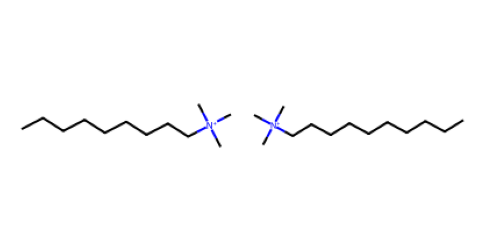

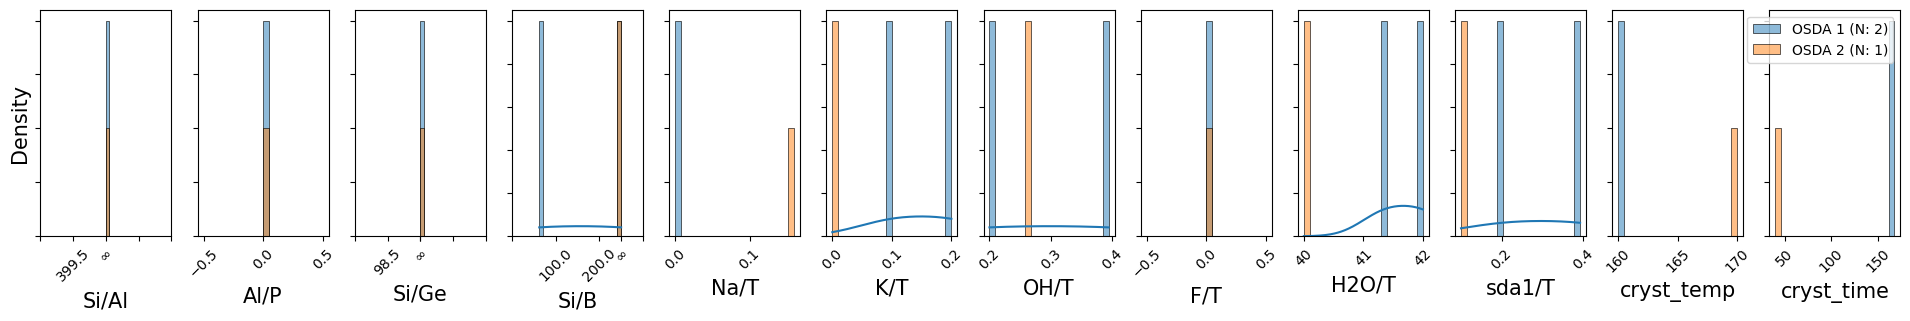

28
zeo: UTL
osda 1: C[C@H]1CCC[C@@H](C)[N+]12Cc1ccccc1C2 5
osda 2: CC1CCCC(C)[N+]12Cc1ccccc1C2 1
osda similarity: 1.0
synthesis similarity: 0.8819448


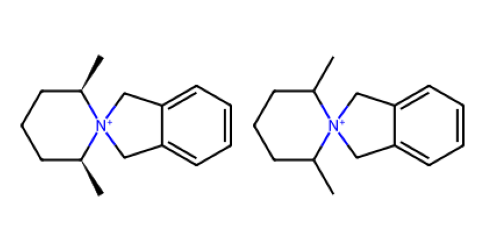

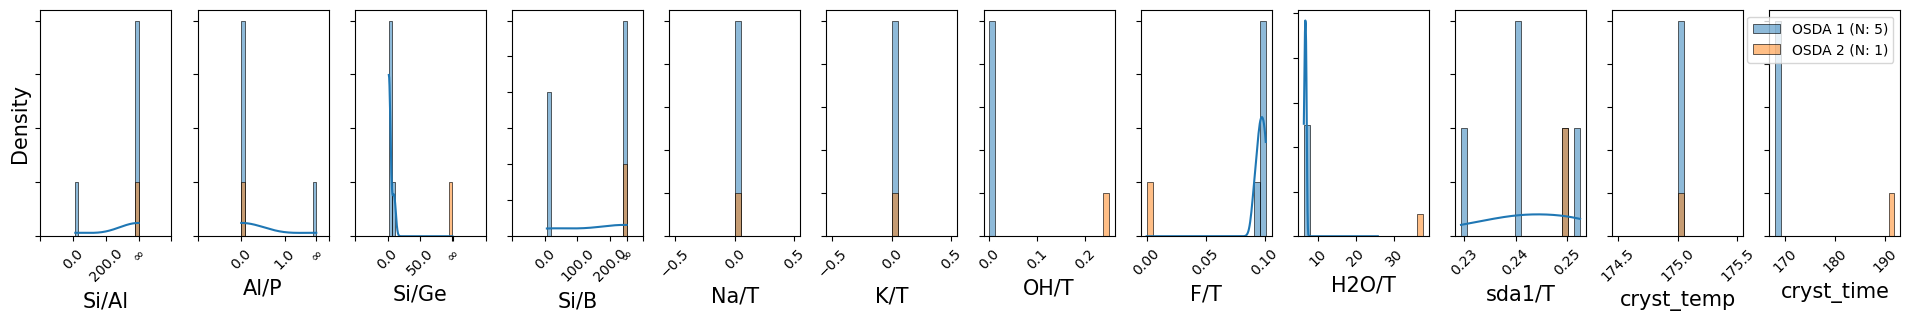

29
zeo: MFI
osda 1: CCCCCCCCCCCCCCCCCCCCCC[N+](C)(C)CCCCCC[N+](C)(C)CCCCCC 25
osda 2: CCCCCCCCCCCCCCCCCC[N+](C)(C)CCCCCC[N+](C)(C)CCCCCC 6
osda similarity: 1.0
synthesis similarity: 0.87780476


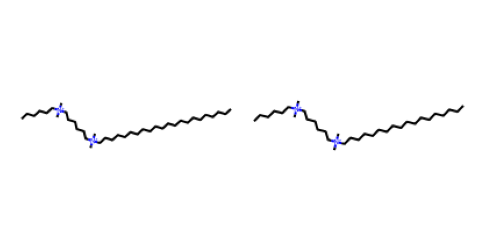

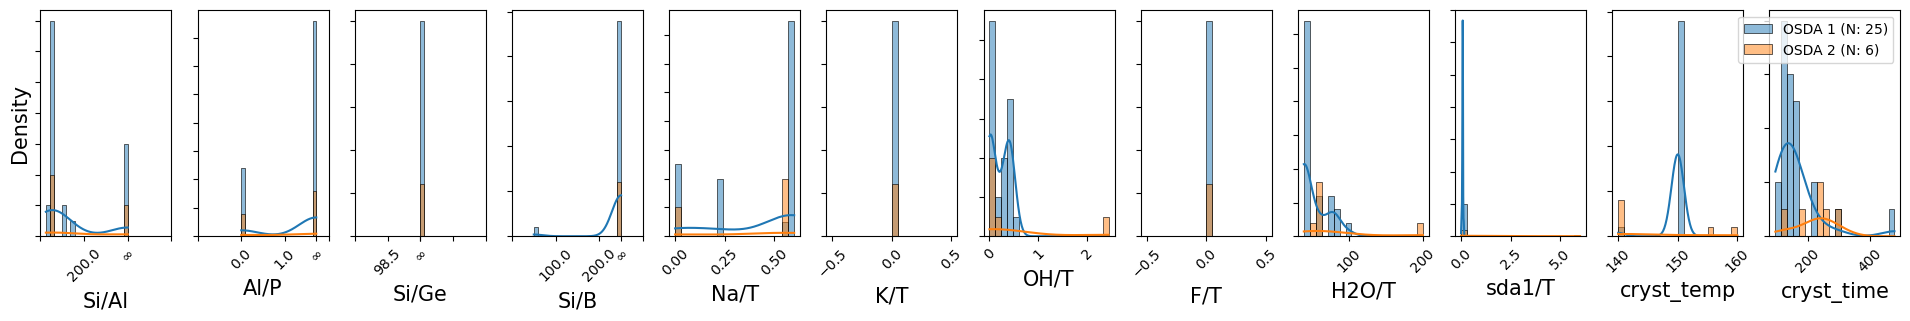

30
zeo: AEI
osda 1: CC[N+]1(CC)[C@@H](C)CCC[C@H]1C 1
osda 2: CC[N+]1(CC)C(C)CCCC1C 1
osda similarity: 1.0
synthesis similarity: 0.00794202


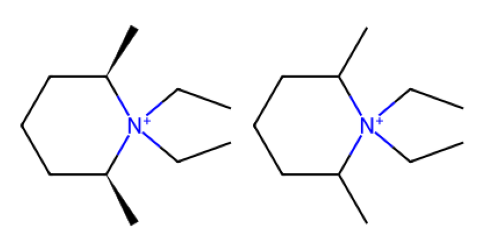

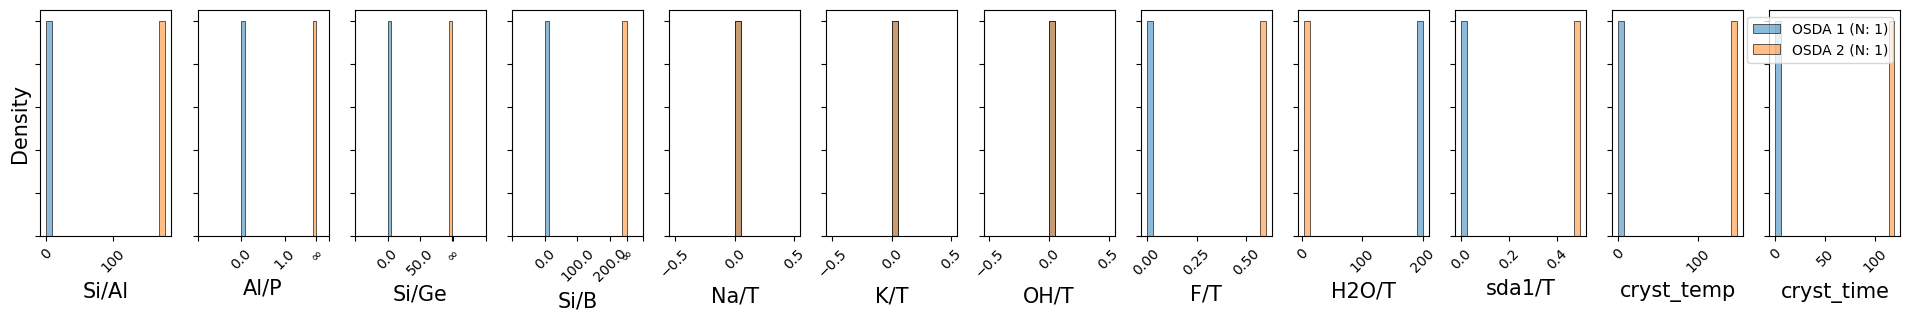

31
zeo: AEI
osda 1: CC1CC(C)C[N+](C)(C)C1 60
osda 2: C[C@H]1C[C@H](C)C[N+](C)(C)C1 1
osda similarity: 1.0
synthesis similarity: 0.9159189


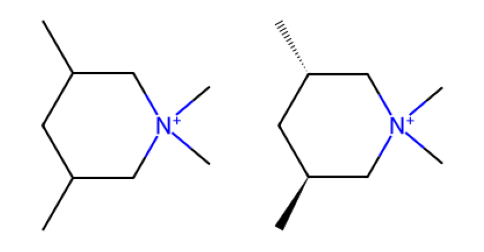

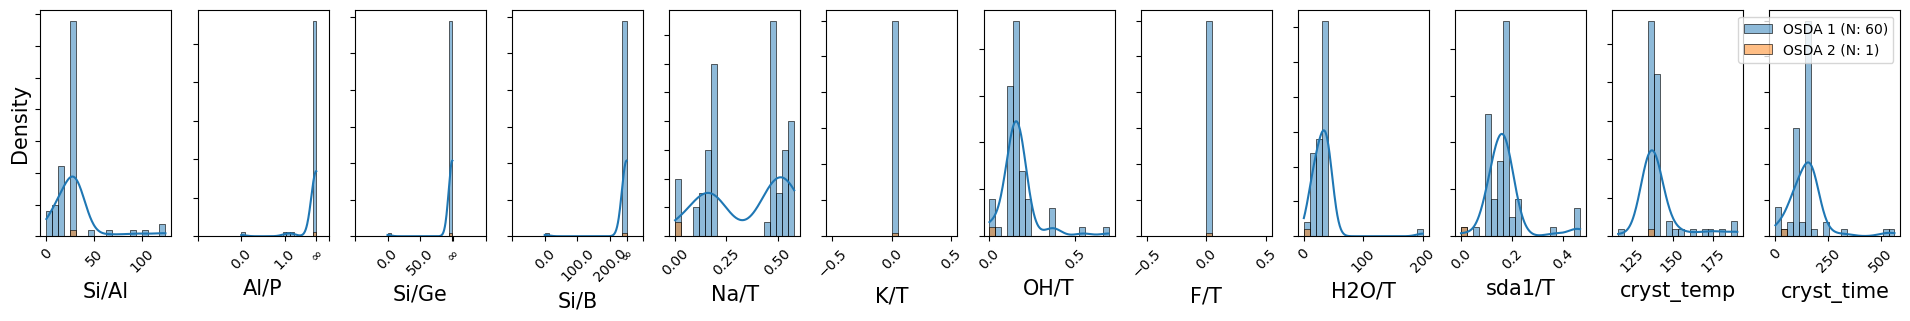

32
zeo: MTW
osda 1: Cc1n(C)cc[n+]1CCCCCCCC[n+]1ccn(C)c1C 7
osda 2: Cc1n(C)cc[n+]1CCCCCCCCCC[n+]1ccn(C)c1C 7
osda similarity: 1.0
synthesis similarity: 0.8814908


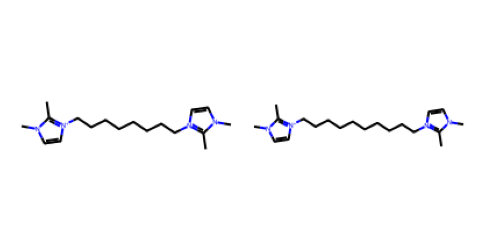

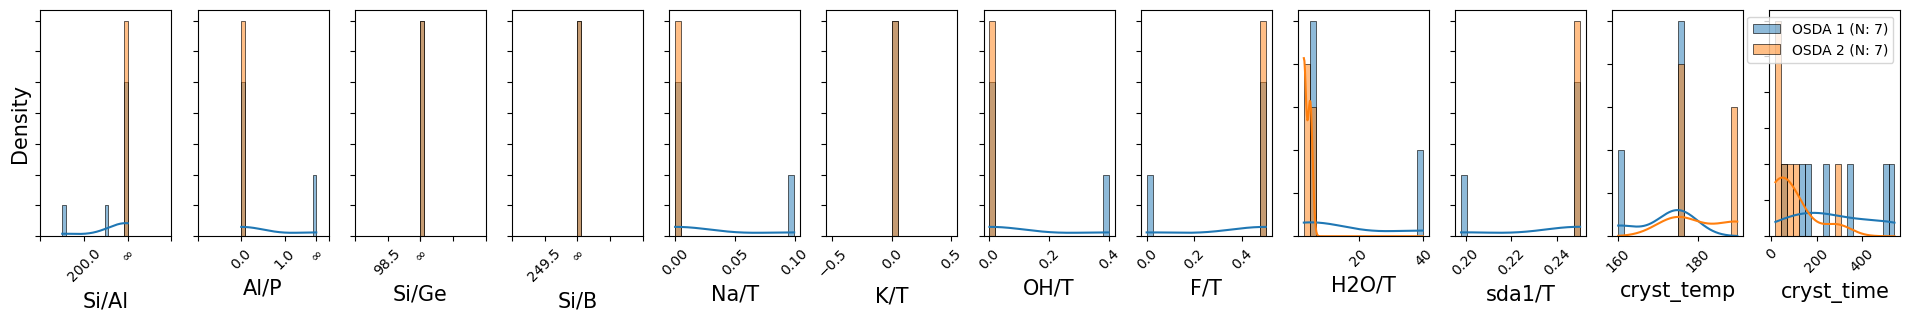

33
zeo: STF
osda 1: CC[N+]1(C)C(C)CCCC1C 5
osda 2: CC[N+]1(C)[C@@H](C)CCC[C@H]1C 1
osda similarity: 1.0
synthesis similarity: 0.39754388


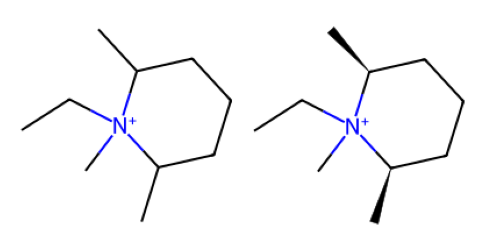

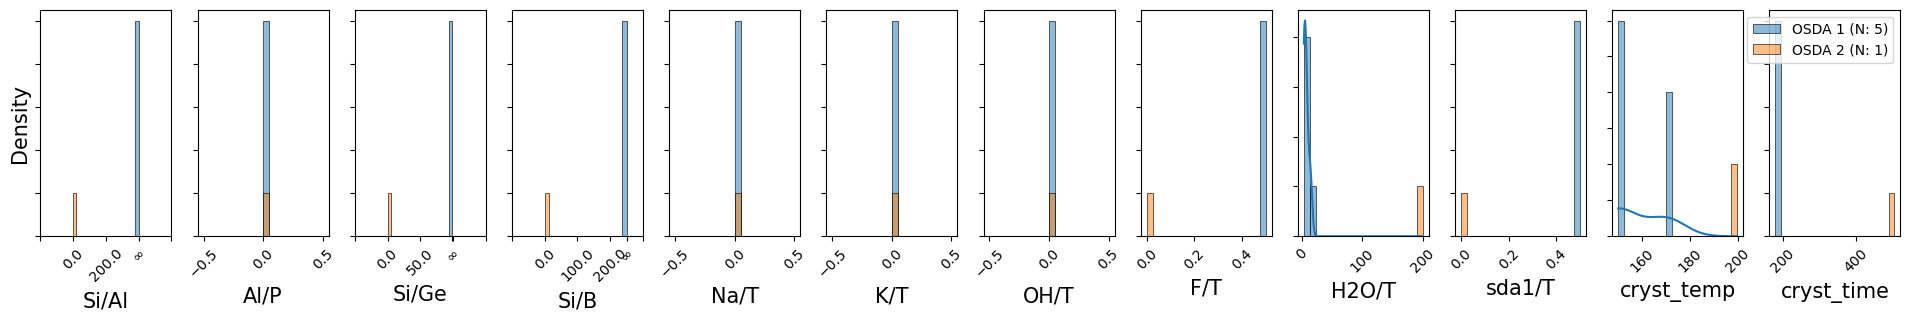

34
zeo: MTT
osda 1: C[N+](C)(C)CCCCCCCCCCCC[N+](C)(C)C 2
osda 2: C[N+](C)(C)CCCCCCCCCCC[N+](C)(C)C 1
osda similarity: 1.0
synthesis similarity: 0.9929917


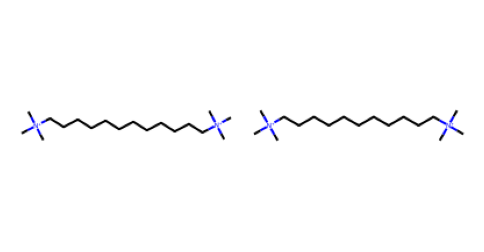

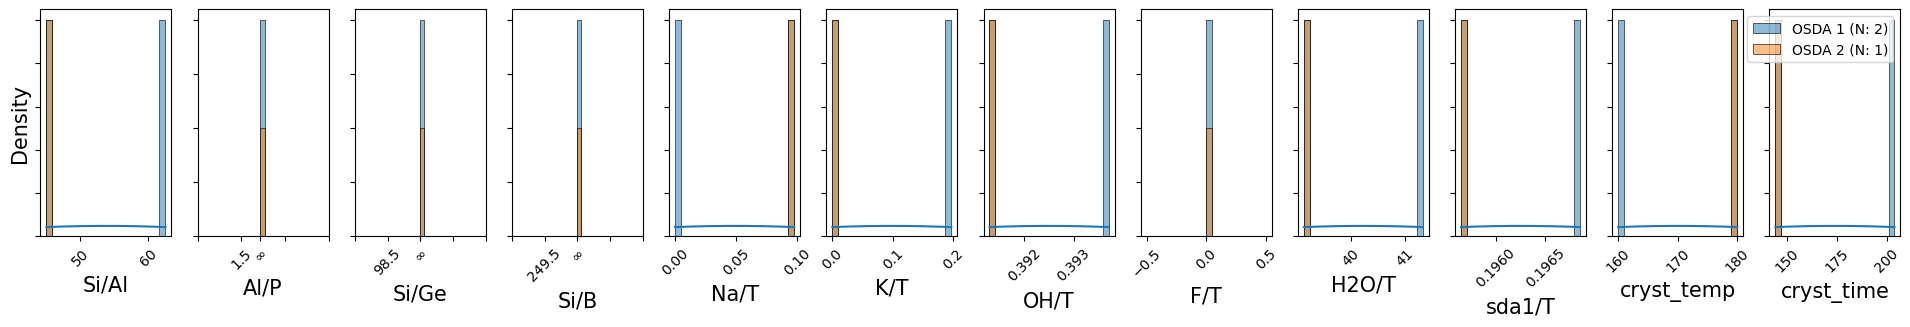

35
zeo: MFI
osda 1: CCC1CCCC[N+]1(C)C 2
osda 2: CC[C@@H]1CCCC[N+]1(C)C 1
osda similarity: 1.0
synthesis similarity: 0.7361247


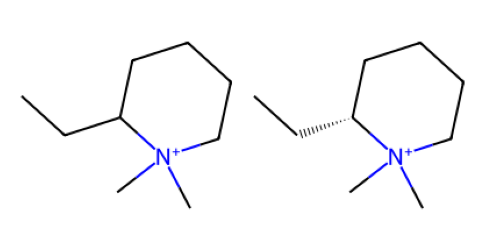

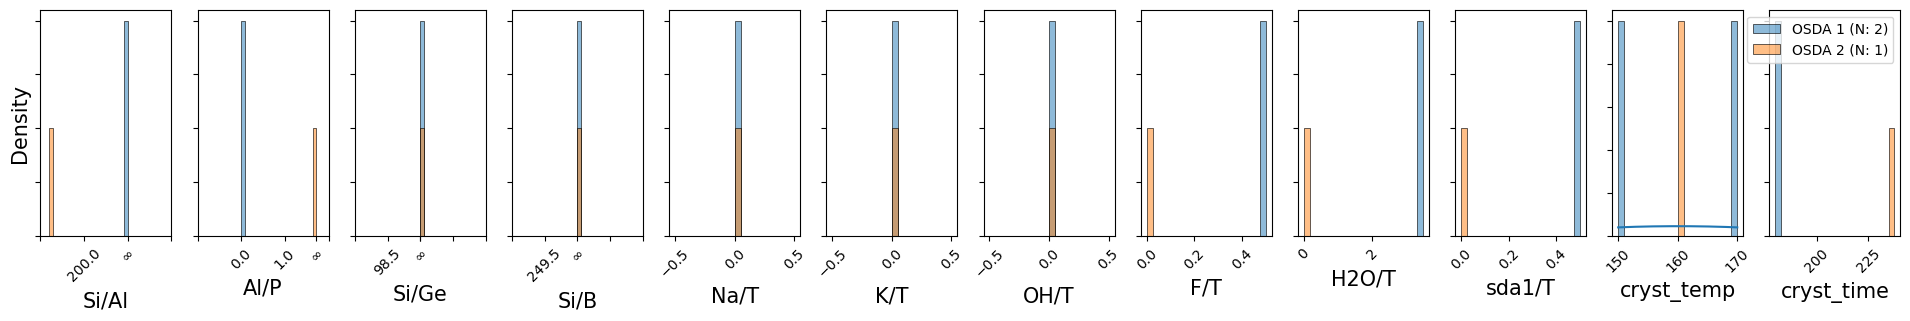

36
zeo: MEL
osda 1: NCCCCCCCCCCCCN 2
osda 2: NCCCCCCCCCN 1
osda similarity: 1.0
synthesis similarity: 0.2976273


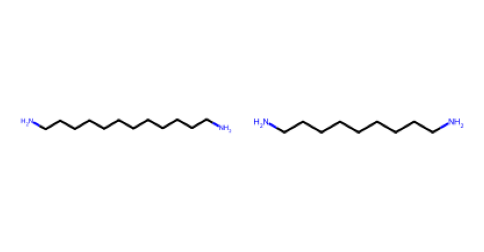

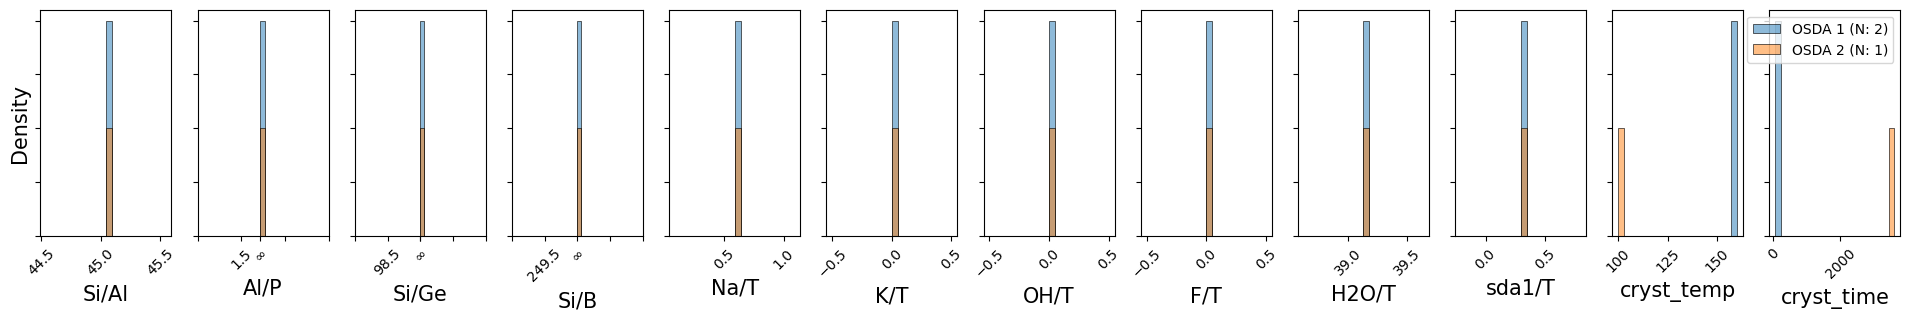

37
zeo: MEL
osda 1: NCCCCCCCN 2
osda 2: NCCCCCCCCCN 1
osda similarity: 1.0
synthesis similarity: 0.8317745


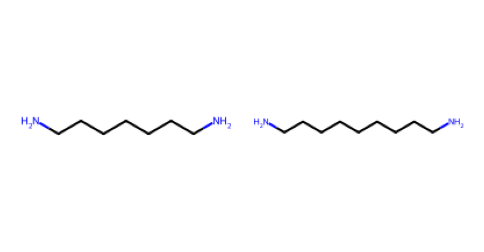

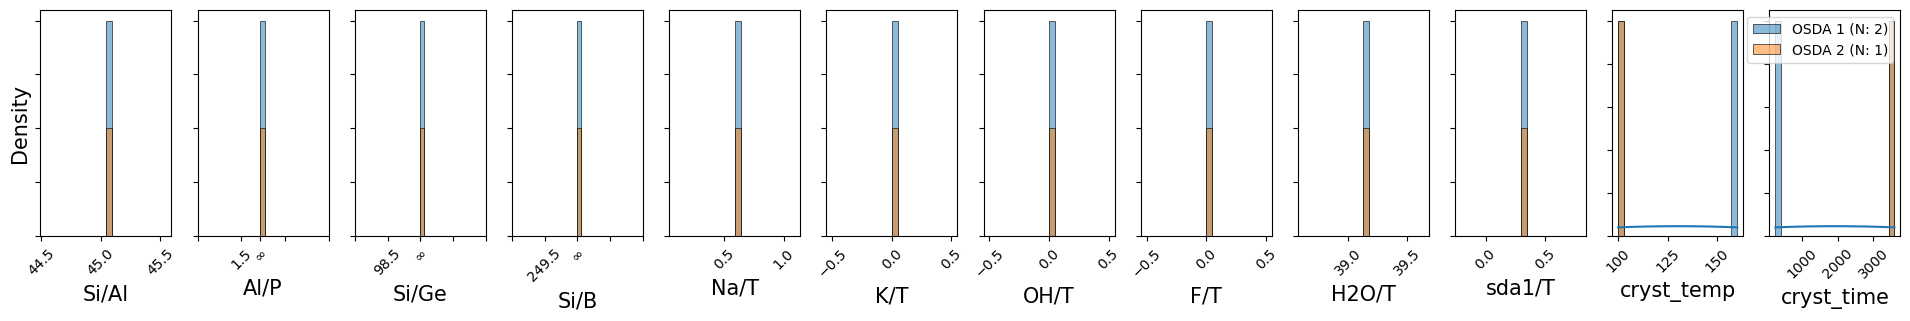

38
zeo: CHA
osda 1: NCCNCCNCCNCCN 40
osda 2: NCCNCCNCCNCCNCCN 2
osda similarity: 1.0
synthesis similarity: 0.9475435


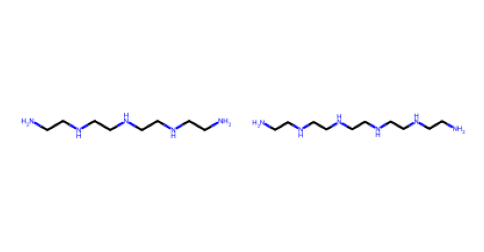

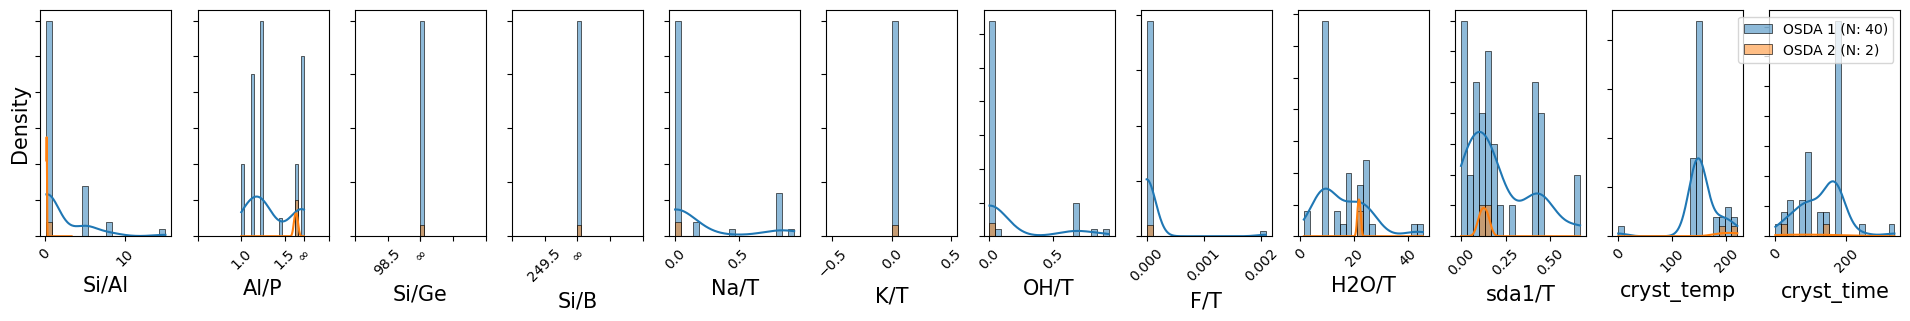

39
zeo: EMT
osda 1: C1COCCOCCOCCOCCOCCO1 47
osda 2: C1COCCOCCOCCOCCO1 20
osda similarity: 1.0
synthesis similarity: 0.91043794


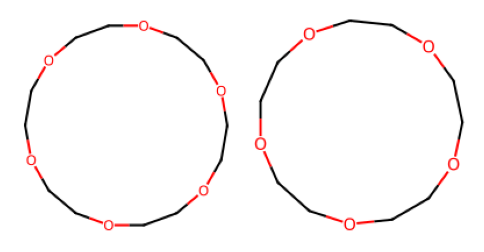

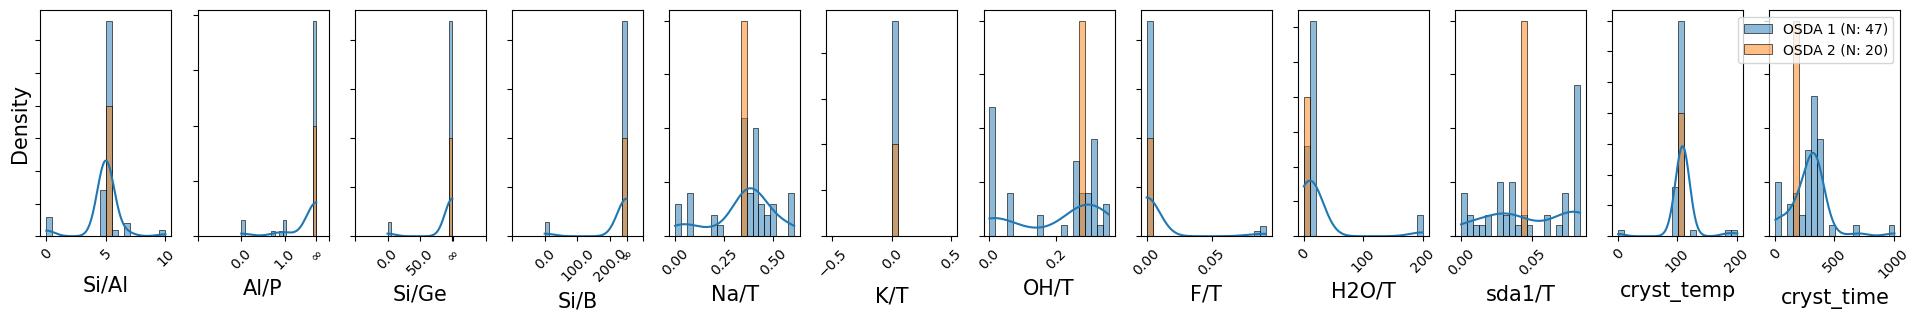

40
zeo: AEI
osda 1: CC1CC(C)C[N+](C)(C)C1 60
osda 2: C[C@H]1C[C@@H](C)C[N+](C)(C)C1 14
osda similarity: 1.0
synthesis similarity: 0.95521617


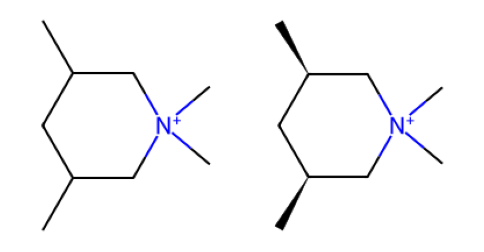

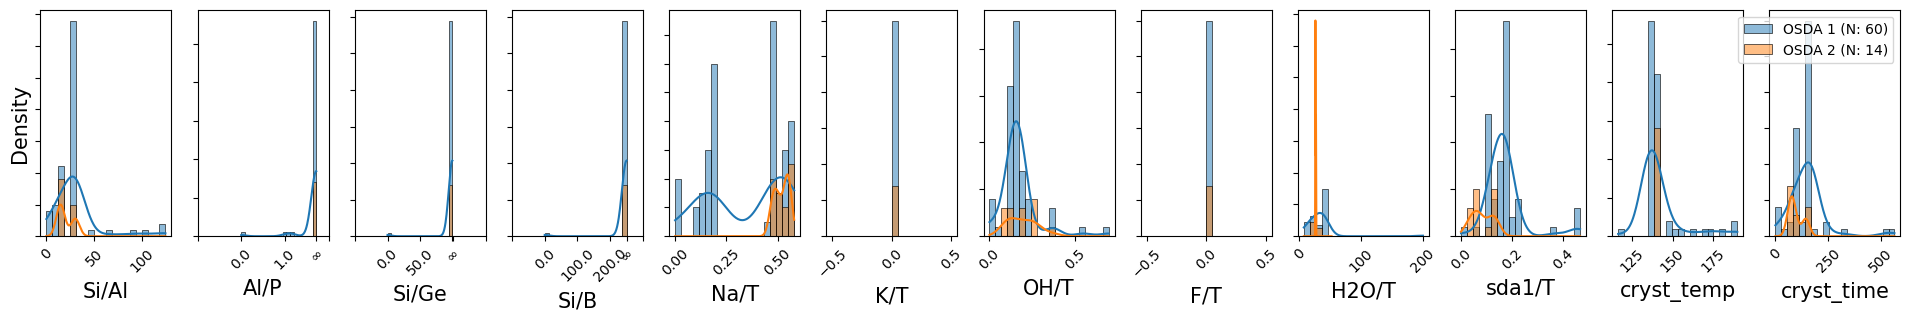

41
zeo: AEI
osda 1: CC1CCCC(C)[N+]1(C)C 4
osda 2: C[C@H]1CCC[C@@H](C)[N+]1(C)C 3
osda similarity: 1.0
synthesis similarity: 0.96687245


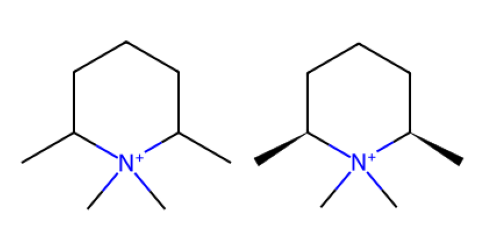

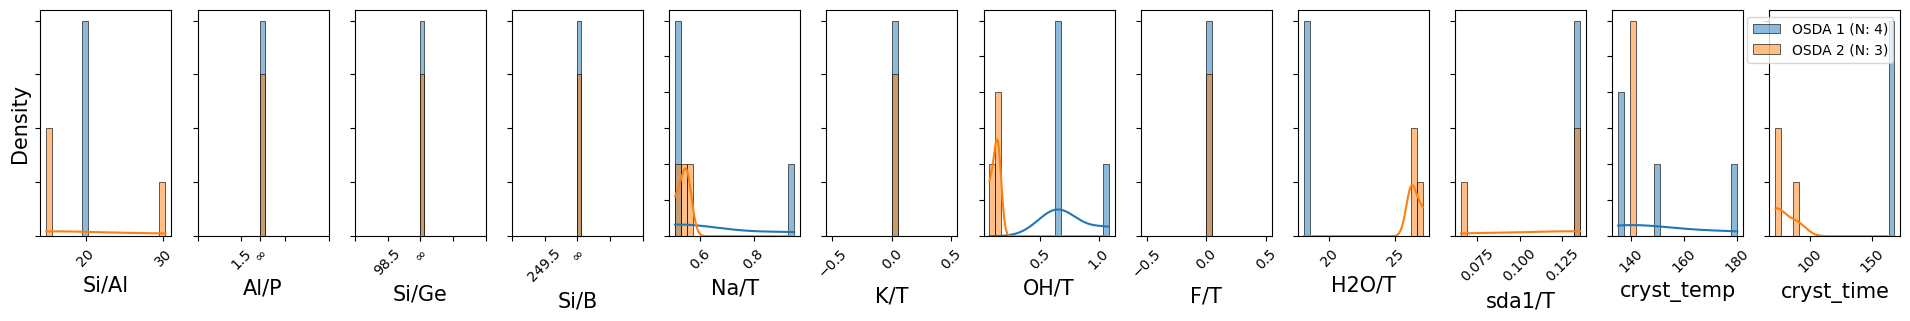

42
zeo: STF
osda 1: C[C@H]1CCC[C@@H](C)[N+]12CCCC2 12
osda 2: CC1CCCC(C)[N+]12CCCC2 8
osda similarity: 1.0
synthesis similarity: 0.722069


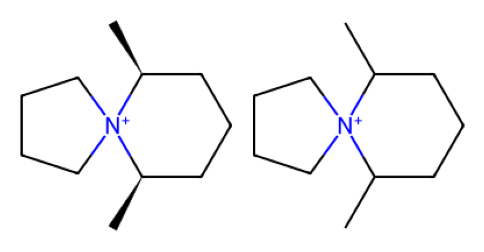

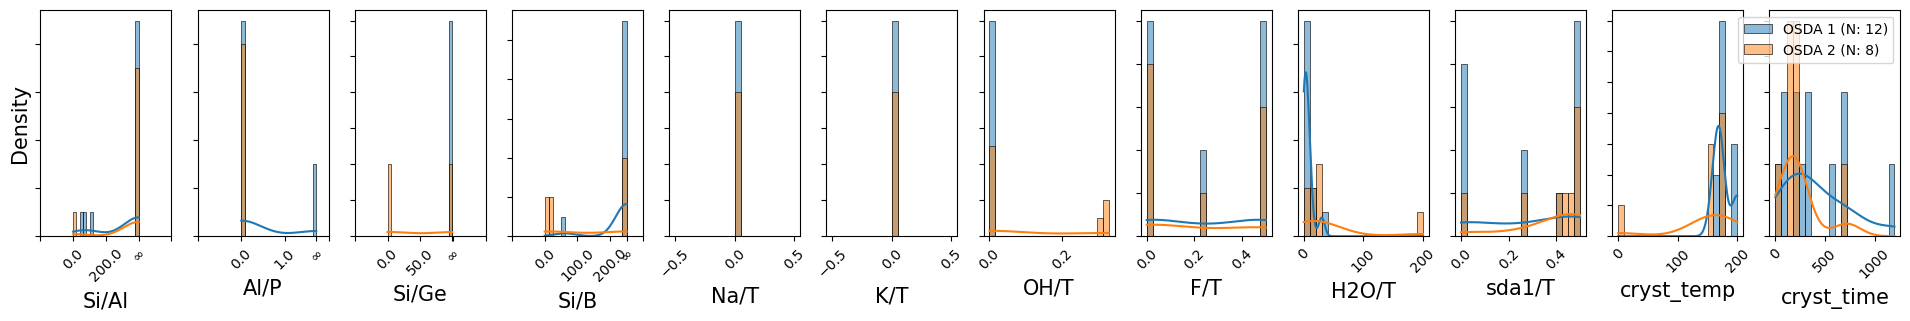

43
zeo: MEL
osda 1: NCCCCCCCCN 10
osda 2: NCCCCCCCCCCN 1
osda similarity: 1.0
synthesis similarity: 0.71988744


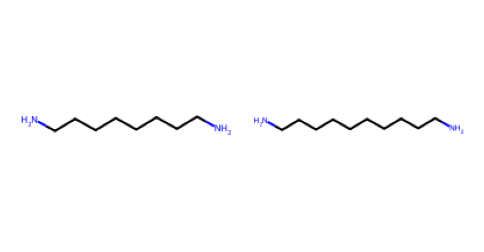

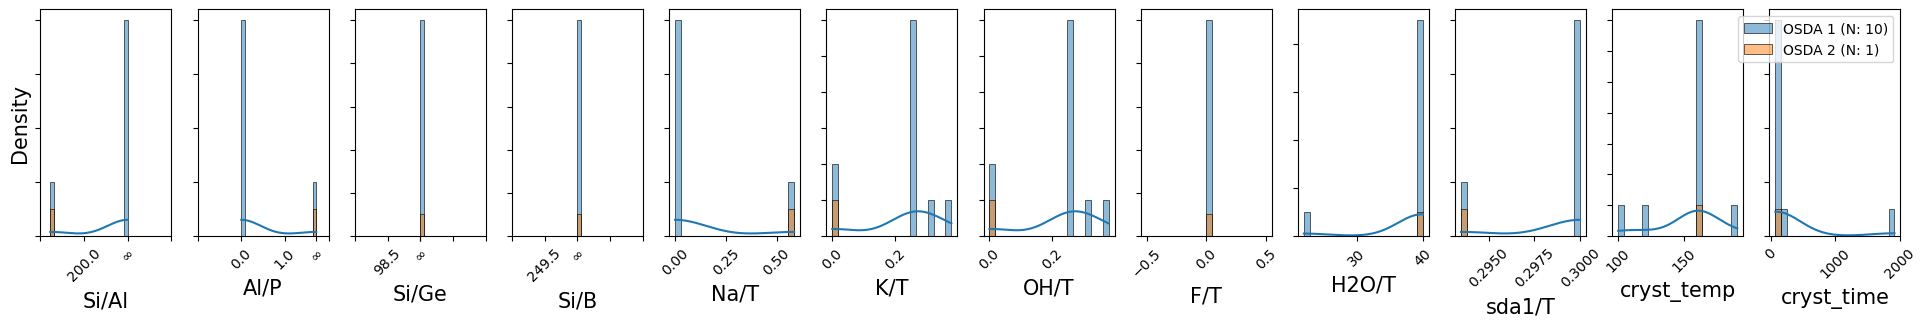

44
zeo: MFI
osda 1: C[N+](C)(C)CCCCCCCC[N+](C)(C)C 4
osda 2: C[N+](C)(C)CCCCCCCCCC[N+](C)(C)C 3
osda similarity: 1.0
synthesis similarity: 0.85571766


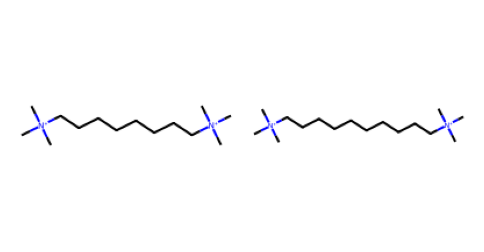

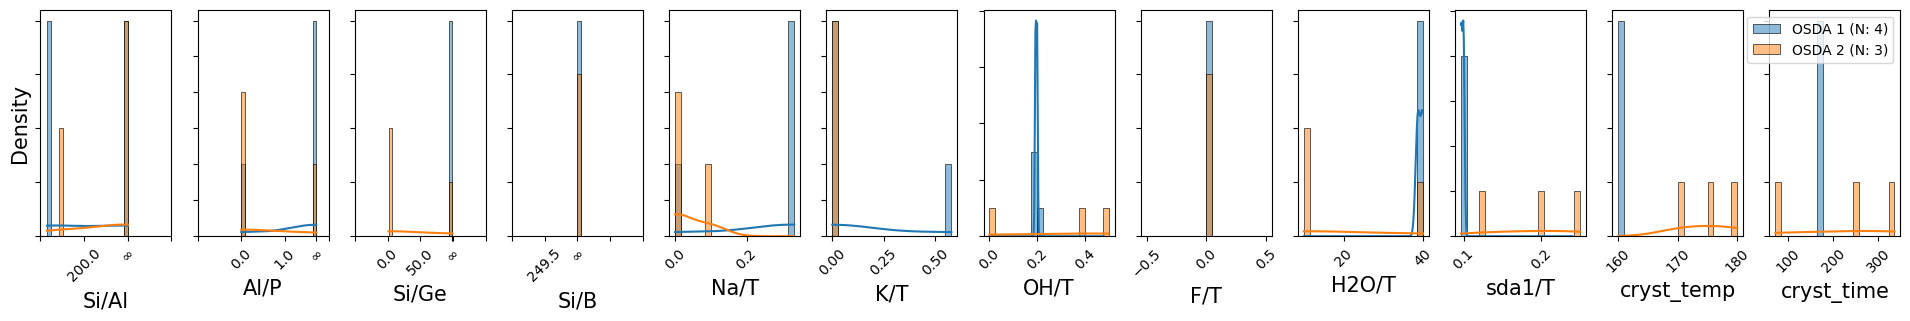

45
zeo: MEL
osda 1: NCCCCCCCCCN 1
osda 2: NCCCCCCCCCCN 1
osda similarity: 1.0
synthesis similarity: 0.2976273


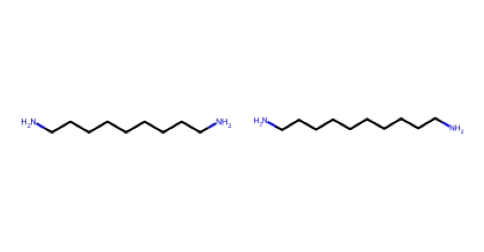

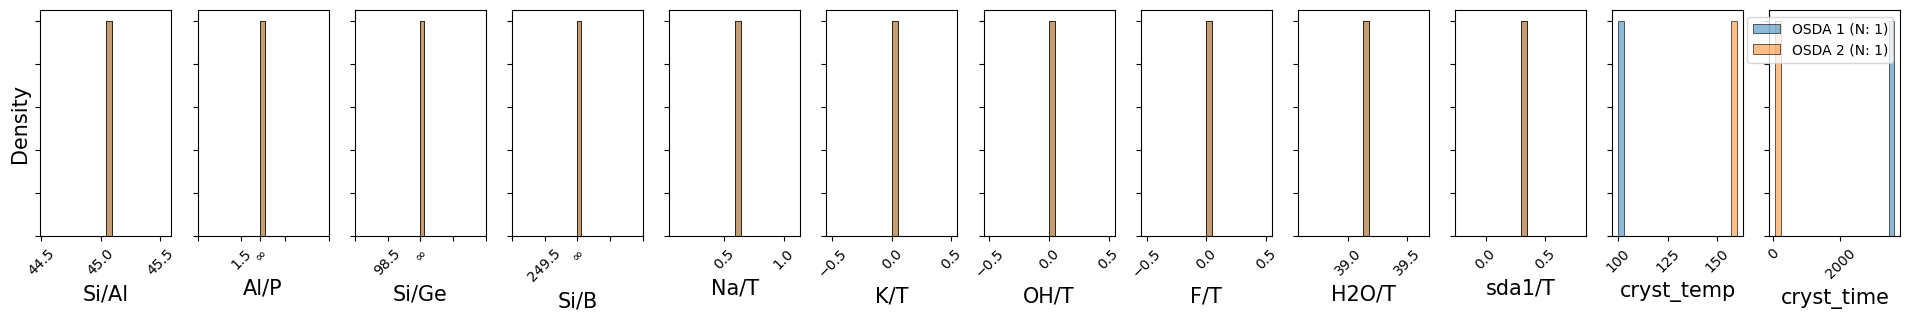

46
zeo: MEL
osda 1: NCCCCCCCCCCCCN 2
osda 2: NCCCCCCCCCCN 1
osda similarity: 1.0
synthesis similarity: 1.0000001


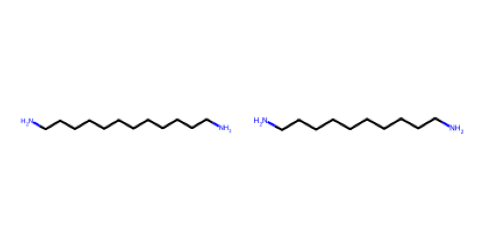

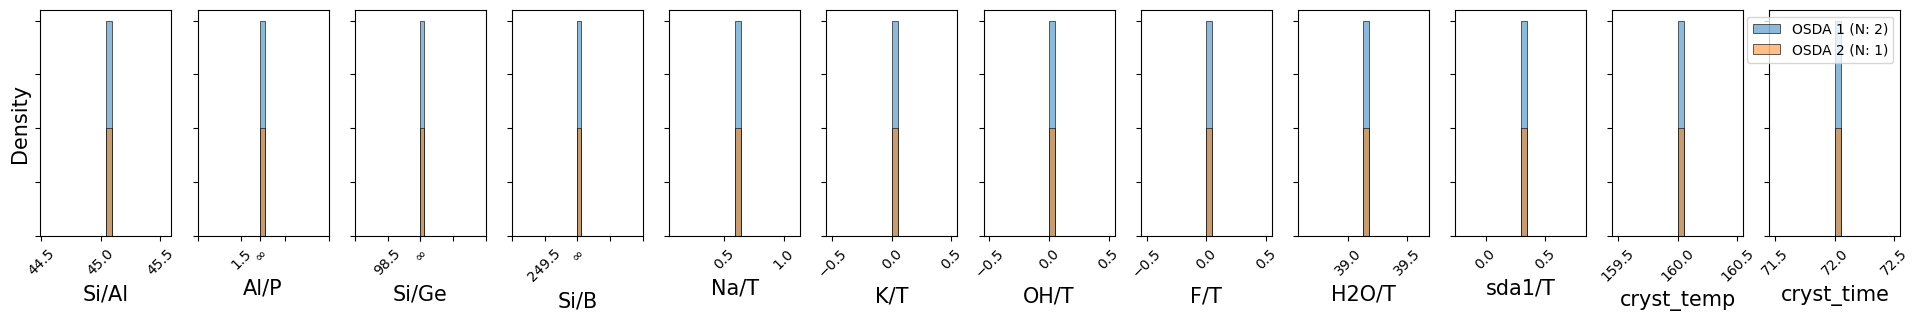

47
zeo: MEL
osda 1: NCCCCCCCN 2
osda 2: NCCCCCCCCCCN 1
osda similarity: 1.0
synthesis similarity: 0.6046611


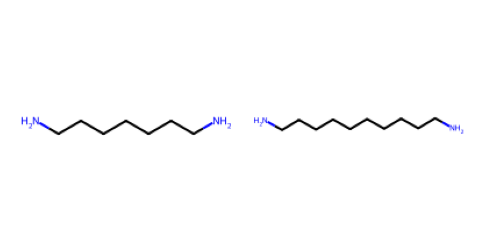

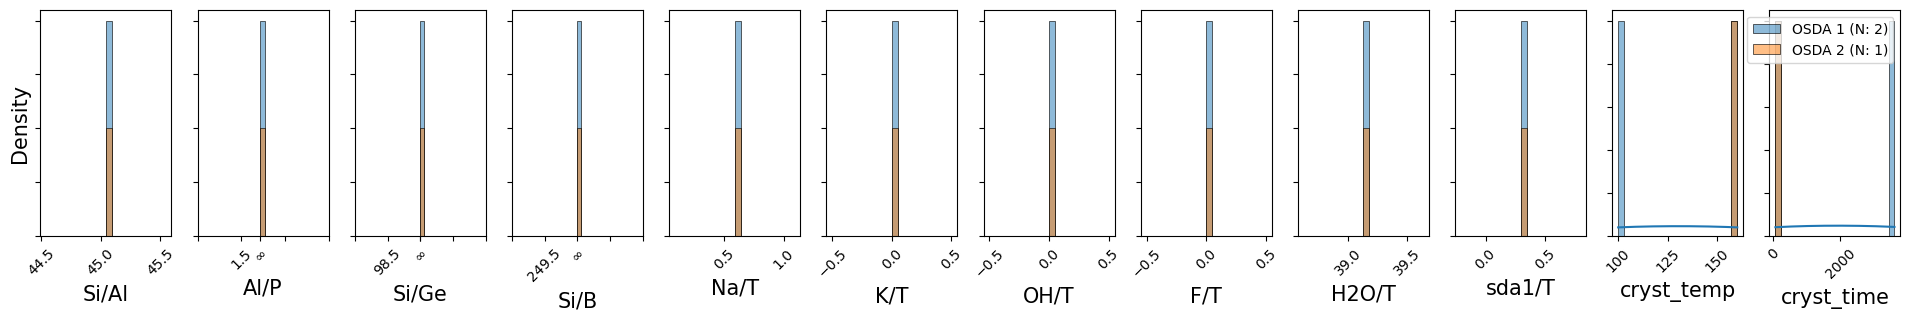

48
zeo: FAU
osda 1: C1COCCOCCOCCOCCOCCO1 29
osda 2: C1COCCOCCOCCOCCO1 25
osda similarity: 1.0
synthesis similarity: 0.86471677


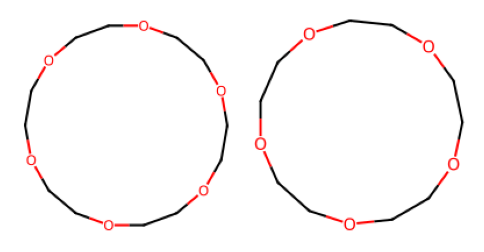

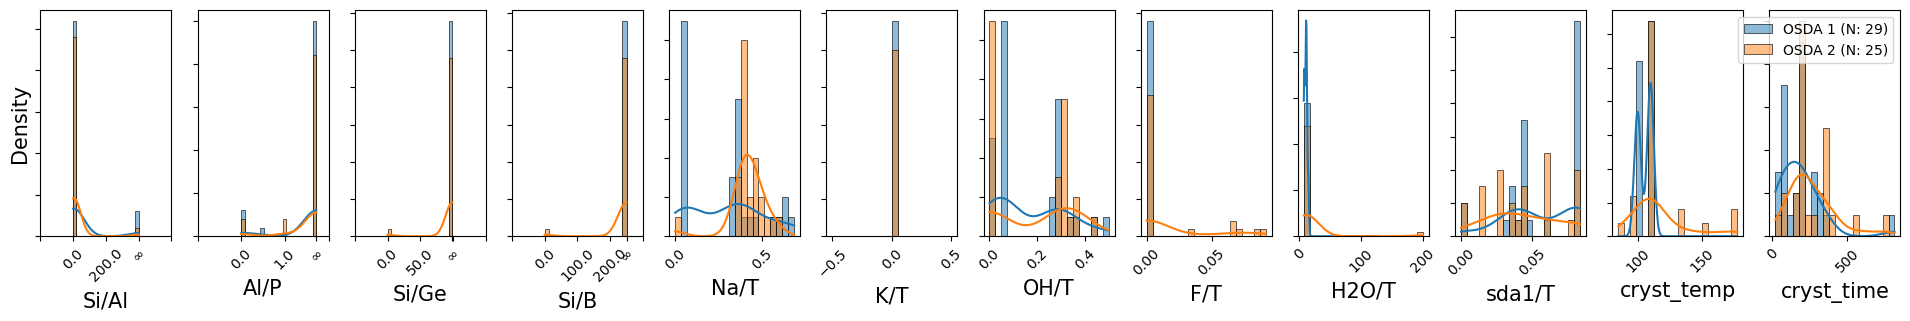

49
zeo: FAU
osda 1: C1COCCOCCOCCOCCN1 6
osda 2: C1COCCOCCOCCOCCOCCN1 4
osda similarity: 1.0
synthesis similarity: 0.9999698


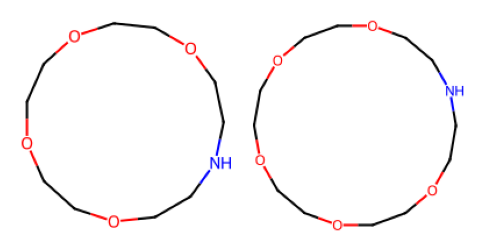

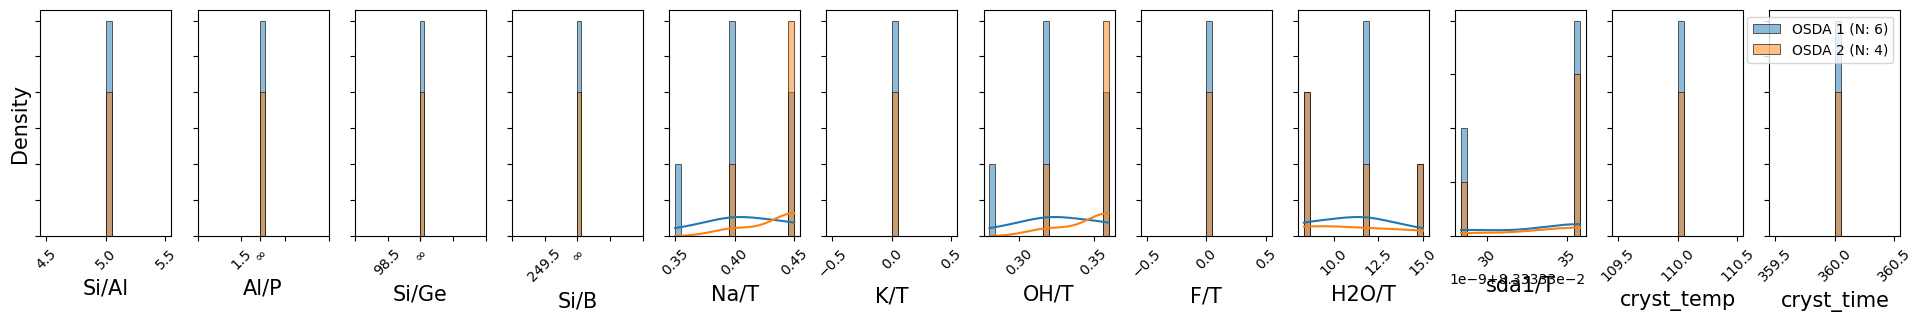

50
zeo: BEA
osda 1: Cc1n(C)cc[n+]1CCCCCCCC[n+]1ccn(C)c1C 3
osda 2: Cc1n(C)cc[n+]1CCCCCCCCCC[n+]1ccn(C)c1C 2
osda similarity: 1.0
synthesis similarity: 0.9843128


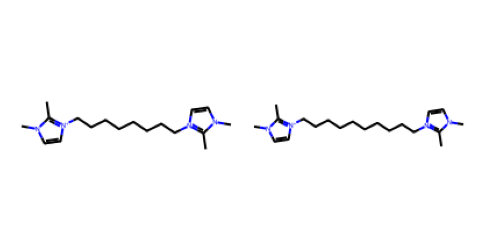

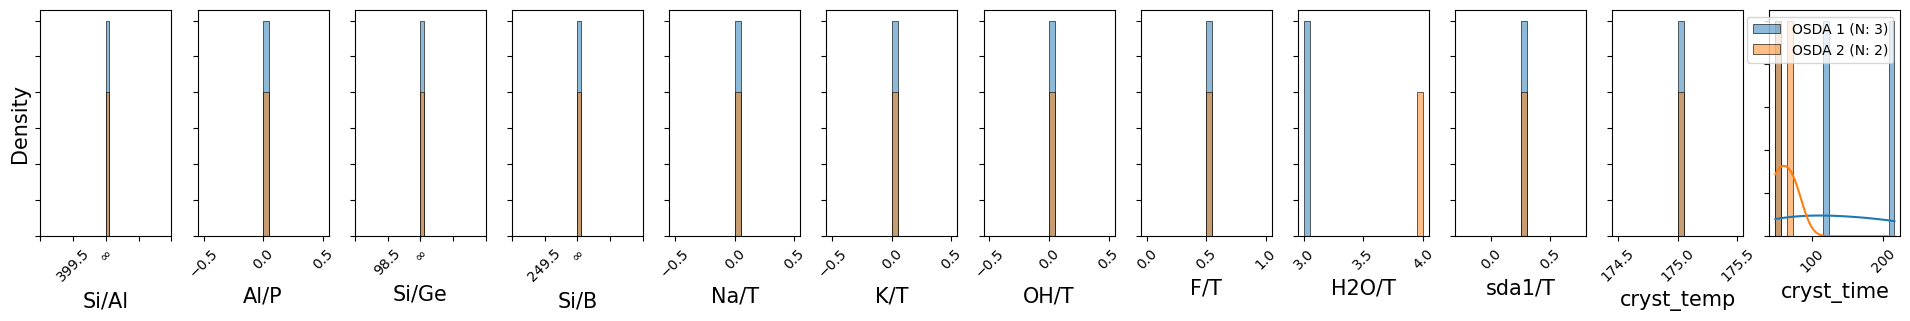

In [10]:
for idx in range(len(df_osda_sim)):
    data = df_osda_sim.iloc[idx]
    zeo, osda_src, osda_ref, osda_sim, syn_sim = data['zeo'], data['osda_src'], data['osda_ref'], data['osda_sim'], data['syn_sim']

    df_zeo = df[df['zeo']==zeo]
    df_zeo = df_zeo.drop(columns=['zeo'])

    df_zeo_osda_src = df_zeo[df_zeo['osda']==osda_src].drop(columns=['osda'])
    df_zeo_osda_ref = df_zeo[df_zeo['osda']==osda_ref].drop(columns=['osda']) 

    print(idx)
    print('zeo:', zeo)
    print('osda 1:', osda_src, len(df_zeo_osda_src))
    print('osda 2:', osda_ref, len(df_zeo_osda_ref))
    print('osda similarity:', osda_sim)
    print('synthesis similarity:', syn_sim)
    
    visualize_smiles([osda_src, osda_ref])
    compare_gel_conds(df_zeo_osda_src, df_zeo_osda_ref, kde=True)

    if idx == 50:
        break


# (Just) Zeolite similarity

In [15]:
unique_zeo = list(df['zeo'].value_counts().keys())

zeo_sims, syn_sims = [], [] 
zeo_refs, zeo_srcs = [], []

for ref_idx in tqdm.tqdm(range(len(unique_zeo))):

    zeo_ref = unique_zeo[ref_idx] # Reference zeo

    if zeo_ref != 'Dense/Amorphous':
        df_zeo_ref = df[df['zeo']==zeo_ref].drop(columns=['zeo', 'osda'])

        for src_idx in range(ref_idx):  # Lower triangular matrix WITHOUT diagonal (diagonal is self-similarity, which is not useful)
            
            zeo_src = unique_zeo[src_idx] # Source zeo-OSDA

            if zeo_src != 'Dense/Amorphous':
                df_zeo_src = df[df['zeo']==zeo_src].drop(columns=['zeo', 'osda'])

                # 1) ZEOLITE SIMILARITY
                zeo_sim = get_zeolite_similarity(zeo_src, zeo_ref, feat_type='be')

                # 2) SYNTHESIS SIMILARITY
                syn_sim = cosine_similarity(df_zeo_src.values, df_zeo_ref.values) # n_samples_X, n_samples_Y
                syn_sim = syn_sim.mean() # scalar

                zeo_sims.append(zeo_sim), syn_sims.append(syn_sim)
                zeo_refs.append(zeo_ref), zeo_srcs.append(zeo_src)

100%|██████████| 233/233 [00:49<00:00,  4.71it/s]


In [12]:
df_zeo_sim = pd.DataFrame({'zeo_ref': zeo_refs, 'zeo_src': zeo_srcs, 'zeo_sim': zeo_sims, 'syn_sim': syn_sims})
# df_zeo_sim.to_csv('df_zeo_sim.csv')

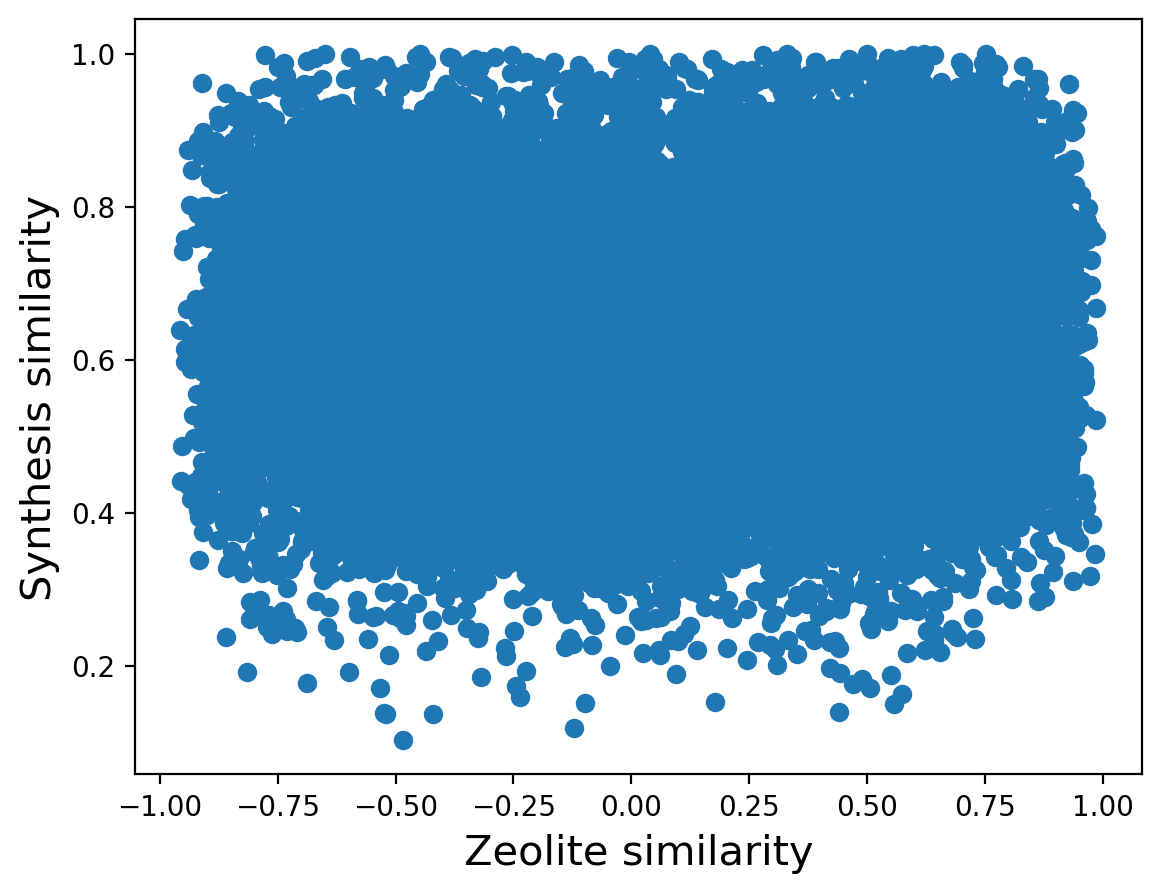

In [22]:
plt.figure(figsize=(6.5,5),dpi=200)
plt.scatter(zeo_sims, syn_sims)
# plt.hexbin(zeo_sims, syn_sims, cmap='inferno')
# ax = plt.gca()
# ax.set_facecolor('black')
plt.xlabel('Zeolite similarity', fontsize=15)
plt.ylabel('Synthesis similarity', fontsize=15)
# cb = plt.colorbar()
# cb.set_label('Number of zeolite pairs', fontsize=15)
# plt.xlim(-0.00,1.015)
# plt.ylim(-0.02,1.015)
# plt.xlim(-0.00,1.02)
# plt.ylim(-0.01,2)
plt.show()

# Zeolite-OSDA similarity

In [14]:
# unique_zeo_osda = list(df[['zeo', 'osda']].value_counts().keys())

# zeo_sims, osda_sims, syn_sims = [], [], []
# zeo_refs, osda_refs, zeo_srcs, osda_srcs = [], [], [], []

# for ref_idx in tqdm.tqdm(range(len(unique_zeo_osda))):

#     zeo_ref, osda_ref = unique_zeo_osda[ref_idx] # Reference zeo-OSDA

#     if (zeo_ref != 'Dense/Amorphous') and (osda_ref != 'OSDA-free'):
#         df_zeo_osda_ref = df[(df['zeo']==zeo_ref) & (df['osda']==osda_ref)].drop(columns=['zeo', 'osda'])

#         for src_idx in range(ref_idx):  # Lower triangular matrix WITHOUT diagonal (diagonal is self-similarity, which is not useful)
            
#             zeo_src, osda_src = unique_zeo_osda[src_idx] # Source zeo-OSDA

#             if (zeo_src != 'Dense/Amorphous') and (osda_src != 'OSDA-free'):
#                 df_zeo_osda_src = df[(df['zeo']==zeo_src) & (df['osda']==osda_src)].drop(columns=['zeo', 'osda'])

#                 # 1) ZEOLITE SIMILARITY
#                 zeo_sim = get_zeolite_similarity(zeo_src, zeo_ref, feat_type='be')

#                 # 2) OSDA SIMILARITY
#                 osda_sim = calculate_tanimoto_similarity(osda_src, osda_ref, plot=False) # compare to refence OSDA

#                 # 3) SYNTHESIS SIMILARITY
#                 syn_sim = cosine_similarity(df_zeo_osda_src.values, df_zeo_osda_ref.values) # n_samples_X, n_samples_Y
#                 syn_sim = syn_sim.mean() # scalar

#                 zeo_sims.append(zeo_sim), osda_sims.append(osda_sim), syn_sims.append(syn_sim)
#                 zeo_refs.append(zeo_ref), osda_refs.append(osda_ref), zeo_srcs.append(zeo_src), osda_srcs.append(osda_src)

  5%|▌         | 130/2572 [00:13<04:17,  9.49it/s]


KeyboardInterrupt: 

In [ ]:
# df_zeo_osda_sim = pd.DataFrame({'zeo_ref': zeo_refs, 'osda_ref': osda_refs, 'zeo_src': zeo_srcs, 'osda_src': osda_srcs, 'zeo_sim': zeo_sims, 'osda_sim': osda_sims, 'syn_sim': syn_sims})
# df_zeo_osda_sim.to_csv('zeo_osda_sim-syn_cos_sim-zeo_be.csv')

In [ ]:
import matplotlib as mpl
mpl.rcParams['agg.path.chunksize'] = 1000
plt.figure(figsize=(6.5,5),dpi=100)
plt.hexbin(df_zeo_osda_sim['zeo_sim'], df_zeo_osda_sim['syn_sim'], gridsize=30, bins='log', cmap='inferno')
ax = plt.gca()
ax.set_facecolor('black')
plt.xlabel('Zeolite binding similarity')
plt.ylabel('Synthesis MMD dissimilarity')
plt.show()